# Read me

ルール無視で適当に書いてます。
質問があれば
yutaka.higashis3@gmail.com
まで。

# ライブラリ

In [120]:
import csv
import datetime as dt
import math
import os
import re
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import optimize
from matplotlib import animation
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn import linear_model
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import PolynomialFeatures
from scipy.optimize import minimize

#自作モジュール用フォルダにパスを通す
print(os.getcwd())
module_path = os.getcwd()[:-len('notebook')] + 'my_module'
print(module_path)
sys.path.append(module_path)

#自作モジュールと、モジュールアップデート用
#(importlib.reloadをしないとモジュールを書き換えても反映されないため)
import trendline
import dispgraphs
import importlib
import graph_settings

importlib.reload(trendline)
importlib.reload(dispgraphs)
importlib.reload(graph_settings)


C:\Users\user\OneDrive - Kyoto University\shared-Yutaka\Research\Hydrophone\notebook
C:\Users\user\OneDrive - Kyoto University\shared-Yutaka\Research\Hydrophone\my_module


<module 'graph_settings' from 'C:\\Users\\user\\OneDrive - Kyoto University\\shared-Yutaka\\Research\\Hydrophone\\my_module\\graph_settings.py'>

# グラフセッティング

In [121]:
graph_settings.setsettings()

# 初期値設定

In [4]:
# ハイドロフォン長さ
length_hp_m = 0.275
length_C_m = 0.5
pit_width = 0.2
Dv = 0.0125
Dh = 0.0125

W_IDEAL = np.array([0.15, 0.22, 0.29, 0.65, 0.91, 1.96, 3.01, 6.91, 10.81, 50])*0.001
TARGET_TOT = ['-2mm', '3-5mm', '5-6mm', '6-7mm', '7-8.5mm', '8.5-10mm', '10-12.5mm', '12.5-15mm', '15-20mm', '25-30mm', '30mm-']


event_marker = ['.', 'x', 'v', '1', 'D']

suffix = ['_Tot(1)', '_Tot(2)', '_Tot(3)', '_Tot(4)', '_Tot(5)',
            '_Tot(6)', '_Tot(7)', '_Tot(8)', '_Tot(9)', '_Tot(10)']

# 直上中央ハイドロフォン
names_of_center = ['hp'+ s for s in suffix]
# 中央ハイドロフォン
names_of_C = ['C'+ s for s in suffix]
# 中央右ハイドロフォン
names_of_RC = ['RC'+ s for s in suffix]
# 中央左ハイドロフォン
names_of_LC = ['LC'+ s for s in suffix]
# 右ハイドロフォン
names_of_R = ['R'+ s for s in suffix]
# 左ハイドロフォン
names_of_L = ['L'+ s for s in suffix]

# 右鉛直ハイドロフォン
names_of_VR = ['VR'+ s for s in suffix]
# 左鉛直ハイドロフォン
names_of_VL = ['VL'+ s for s in suffix]


# Corrected直上中央ハイドロフォン
names_of_center_Corrected = ['Corrected_hp'+ s for s in suffix]
# Corrected中央ハイドロフォン
names_of_C_Corrected = ['Corrected_C'+ s for s in suffix]
# Corrected中央右ハイドロフォン
names_of_RC_Corrected = ['Corrected_RC'+ s for s in suffix]
# Corrected中央左ハイドロフォン
names_of_LC_Corrected = ['Corrected_LC'+ s for s in suffix]
# Corrected右ハイドロフォン
names_of_R_Corrected = ['Corrected_R'+ s for s in suffix]
# Corrected左ハイドロフォン
names_of_L_Corrected = ['Corrected_L'+ s for s in suffix]



# スロットナンバーと倍率を対応させる
amplification_factor = {'Tot(1)': '1024', 'Tot(2)': '512', 'Tot(3)': '256', 'Tot(4)': '128',
                        'Tot(5)': '64', 'Tot(6)': '32', 'Tot(7)': '16', 'Tot(8)': '8',
                        'Tot(9)': '4', 'Tot(10)': '2'}

# データ読み込み

データが保存されているパスを取得

In [5]:
print(os.getcwd())

data_path = os.getcwd()[:-len('notebook')] + 'data\\'
images_path = os.getcwd()[:-len('notebook')] + 'images\\'
print(data_path)

C:\Users\user\OneDrive - Kyoto University\shared-Yutaka\Research\Hydrophone\notebook
C:\Users\user\OneDrive - Kyoto University\shared-Yutaka\Research\Hydrophone\data\


In [6]:

def read_files_2018_and_2017():
    # read 2018file
    # インデックスをTIMESTANPに設定し，時系列データとして読み込む(index_col='TIMESTAMP', parse_dates=True)
    df01 = pd.read_csv(data_path + 'logger1_2018-03-13_2018-12-16_every1min_withoutRainfall_WL_Velocity.csv',
                       index_col='TIMESTAMP', parse_dates=True)
    df02 = pd.read_csv(data_path + 'logger2_2018-03-13_2018-12-16_every1min_withoutRainfall_WL_Velocity.csv',
                       index_col='TIMESTAMP', parse_dates=True)
    df03 = pd.read_csv(data_path + 'logger3_2018-03-20_2018-12-16_every1min_withoutRainfall_WL_Velocity.csv',
                       index_col='TIMESTAMP', parse_dates=True)
    df04 = pd.read_csv(data_path + 'Precipitation_WL_Velocity201801to201812_every_1min.csv',
                       index_col='TIMESTAMP', parse_dates=True)
    # print(df01,df02,df03,df04)
    
    df_2018 = pd.concat([df01, df02, df03, df04], axis=1, sort=False)

    # read 2017file
    df_2017 = pd.read_csv(data_path + 'Fukadani201607to201711.csv',
                          index_col='TIMESTAMP', parse_dates=True)
    
    return df_2018, df_2017

df_2018, df_2017 = read_files_2018_and_2017()

In [7]:
#ふるい結果を読み込む
df_furui= pd.read_csv(data_path + 'furui_results.csv', index_col='TIMESTAMP', parse_dates=True)

# 汎用性ある関数

## 直線近似

In [8]:
# 重み付き最小二乗法（単純な最小2乗法ではない）
def add_linear_regression(df_X, df_Y, color='r'):
    """
    X:input of x ax(example:x_cols)
    Y:input of y ax(example:x_cols)
    """
    # fit_intercept	False に設定すると切片を求める計算を含めない。
    # 目的変数が原点を必ず通る性質のデータを扱うときに利用。 (デフォルト値: True)
    clf = linear_model.LinearRegression(fit_intercept=False)

    X = df_X.values.reshape(-1, 1)
    Y = df_Y.values.reshape(-1, 1)
    clf.fit(X, Y)
    y_hat = clf.predict(X)

    # 近似直線との誤差を計算する
    diff = Y - y_hat

    # 近似直線との誤差が、比較的が大きい点を無視するような、sample_weightを作成する
    sample_weight = (np.max(np.abs(diff)) - np.abs(diff)
                     ).astype('float32').T[0] ** 2

    # scikit-learnのsolverに、sample_weightを与えて、近似直線を得る
    # 詳しくは"https://medium.com/micin-developers/decipher-github-lr-sw-40e519a13c0a"
    clf.fit(X, Y, sample_weight=sample_weight)
    
    label_slope = "slope:" + str(round(clf.coef_.flatten()[0], 2)) + \
        "\n" + "R^2:" + str(round(clf.score(X, Y), 2))

    # 回帰直線
    plt.plot(X, clf.predict(X), label=label_slope, c=color)
    plt.legend()

    return clf.coef_.flatten()[0]

## 2次曲線近似

In [9]:
#Least squares method with scipy.optimize
def fit_func(parameter, x, y):
    a = parameter[0]
    b = parameter[1]
    c = parameter[2]
    residual = y-(a*x**2+b*x+c)
    return residual

#最小2乗法で変数Cを算出
def least_squares_method(X_list, Y_list):
    parameter0 = [0.,0.,0.]
    result = optimize.leastsq(fit_func,parameter0,args=(X_list,Y_list))
    return result

def plot_least_squares_result(result, X_list, ax):
    a_fit=result[0][0]
    b_fit=result[0][1]
    c_fit=result[0][2]
    print(a_fit, b_fit, c_fit)


    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    x = np.arange(xlim[0], xlim[1], 0.1)

    #PLot#############たぶんここがおかしい
    ax.plot(x,a_fit*x**2+b_fit*x+c_fit, label='fitted parabora', color='r')
    ax.legend(loc='best',fancybox=True, shadow=True)


## ピットの中がa以下b以上のデータをドロップ

In [10]:
def drop_untrusted_pit_data(df, min_pit=200, max_pit=1000):
    df_dropped = df[(df['Load_Avg'] > min_pit)&(df['Load_Avg'] < max_pit)]
    return df_dropped

## グラフクラス

In [11]:
class Graph:
    def __init__(self):
        %matplotlib inline
        
    def set_fig_title_labels(self, ax, title='Title', ylabel='y_name', xlabel='x_name'):
        ax.set_title(title)
        ax.set_ylabel(ylabel)
        ax.set_xlabel(xlabel)
        
    def add_least_squares(self, x, y, ax):
        result = least_squares_method(x, y)
        plot_least_squares_result(result, x, ax)      
        
        
    def time_series_graph(self, df, col_name='Load_Avg'):
        ax = plt.subplot(1, 1, 1)
        df[col_name].plot(ax=ax, ls='none', marker='.', markersize=1)
    
    def scatter_graph(self, df, y_name, x_name, figsize=(5,5), title='Title',
                      ylabel='y_name', xlabel='x_name', alpha=1.0, least_squares=False, linear_regression=False):
        fig = plt.figure(figsize=figsize)
        ax = plt.subplot(1, 1, 1)
        ax.scatter(df[x_name],df[y_name], alpha=alpha)
        self.set_fig_title_labels(ax, title=title, ylabel=ylabel, xlabel=xlabel)
        
        if least_squares:
            self.add_least_squares(df[x_name], df[y_name], ax)
            
        if linear_regression:
            add_linear_regression(df[x_name], df[y_name], color='r')
            
        
    def scatter_graphs(self, df, list_y_names, list_x_names, figsize=(5,5), title='Title', 
                           ylabel='y_name', xlabel='x_name', least_squares=False, alpha=1.0):
        num_graphs = len(list_y_names)
        fig = plt.figure(figsize=figsize)

        for i in range(num_graphs):
            ax = plt.subplot(3, 4, i+1)
            ax.scatter(df[list_x_names[i]], df[list_y_names[i]], alpha=alpha)
            self.set_fig_title_labels(ax, title='Tot({})'.format(i+1), ylabel=list_y_names[i], xlabel=list_x_names[i])
            
        if least_squares:
            self.add_least_squares(df[list_x_names[i]], df[list_y_names[i]], ax)
#             result = least_squares_method(df[list_x_names[i]], df[list_y_names[i]])
#             plot_least_squares_result(result, df[list_x_names[i]], ax)
            
        plt.tight_layout()
        
    def set_xy_lims_for_current_graph(self, xlim, ylim):
        plt.ylim(ylim)
        plt.xlim(xlim)
        pass
    
#     def histogram(self, )
            

# class Time_series_graph(Graph):
#     def __init__(self, df, figsize=(5,3)):
#         self.df = df
#         self.figsize= figsize
        
#     def graph_pit(self):
# #     plt.rcParams['font.family'] = 'Times New Roman'
# #     plt.subplot(121)
#         df['Load_Avg'].plot(ls='none', marker='.', markersize=1)
# #     plt.ylabel('Pit weight[kg]')
# #     plt.subplot(122)
# #     df_2017['Load_Avg'].plot(ls='none', marker='.', markersize=1)
# #     plt.ylabel('Pit weight[kg]')

# 2018年データ

## hpとCのパルス数の相関を表示

hpは27.5cm、Cは50cmのため、パルス数は1対１にならない。/mに直したときに１：１となるはずである。  
しかし、hpの方が先に音の飽和が起こるため、高倍率のデータではパルス数が多い場合、直線ではなく曲線になっている。  
これから、  
ⅰ基本hpとCのパルス数は長さを同じとした場合１：１にしてよい  
ⅱhpの飽和の影響を改善した場合は、Cの飽和の影響は考えなくてよい  

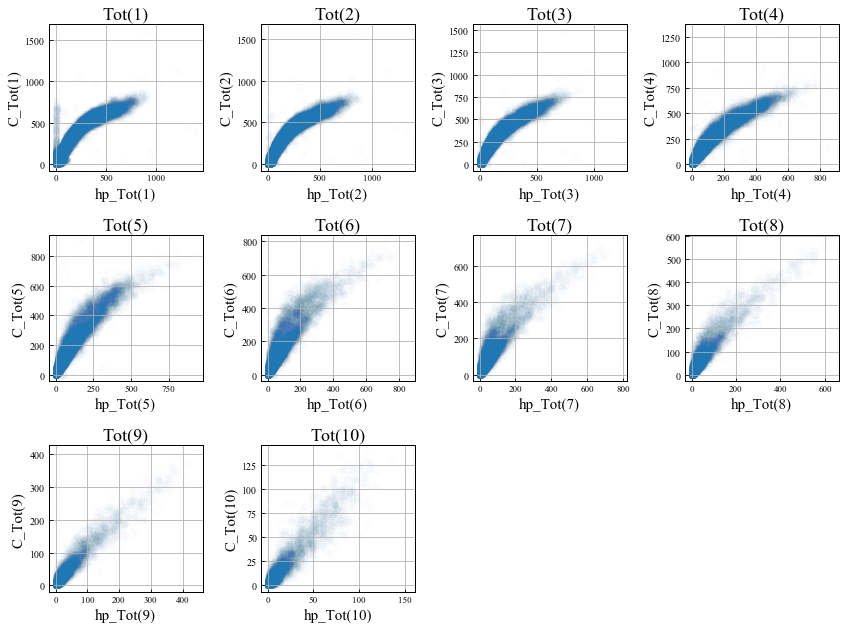

In [12]:
dispgraphs.scatter_graphs(df=df_2018, list_y_names=names_of_C, list_x_names=names_of_center
                             ,figsize=(3*4, 3*3), alpha=0.01)

## Load_Avgの差分をとる

In [13]:
# Load_Avgの差分をとる
df_2018['Load_Avg_difference'] = df_2018['Load_Avg'].diff()
df_2017['Load_Avg_difference'] = df_2017['Load_Avg'].diff()

# #NaNデータを削除
# df_all = df_all.dropna(how='any')

## 縦横補正

縦横補正をする場合は下のコードをコメントアウトして実行。  
私は縦横補正を使っておらず、計算式が間違えている可能性があるので詳しく見たほうがいいかも

In [14]:
# 縦横補正する
def cal_rhv(df):
    #右岸縦横ハイドロフォンによるRhv
    for i, (vr_name, r_name) in enumerate(zip(names_of_VR, names_of_R)):
        df['Rhv_r' + str(i+1)] = (df[vr_name]/df['WaterLevel(cm)'])/(df[r_name]/(length_C_m*Dh))
    #左岸縦横ハイドロフォンによるRhv
    for i, (vl_name, l_name) in enumerate(zip(names_of_VL, names_of_L)):
        df['Rhv_l' + str(i+1)] = (df[vl_name]/df['WaterLevel(cm)'])/(df[l_name]/(length_C_m*Dh))
        
# cal_rhv(df_2018)
    
def cal_corrected(df, side='right', position=1):
    """
    side: right or left
    position:position to the side(1 or 2 or 3)
    
    """
    if side == 'right':
        v_names = names_of_VR
        vh_names = names_of_R
        
        if position == 1:
            h_names = names_of_R
        elif position == 2:
            h_names = names_of_RC
        elif position == 3:
            h_names = names_of_C
    else:
        v_names = names_of_VL
        vh_names = names_of_L

        if position == 1:
            h_names = names_of_L
        elif position == 2:
            h_names = names_of_LC
        
    for h_name, v_name, vh_name in zip(h_names, v_names, vh_names):
        df['Corrected_' + h_name] = df[v_name] / df[vh_name] * length_C_m /Dv * df[h_name]

######################################################
# cal_corrected(df_2018, side='right', position=1)
# cal_corrected(df_2018, side='right', position=2)
# cal_corrected(df_2018, side='right', position=3)
# cal_corrected(df_2018, side='left', position=1)
# cal_corrected(df_2018, side='left', position=2)
######################################################


## ハイドロフォンデータをm^（-2）に変換

In [15]:
# ハイドロフォンデータとピットデータをm^(-1)に変える
def change_dementions_of_hydrophones_and_pit_data(year):
    """
    year:2018 or 2017
    """
    
    if year == 2018:
        colnames_of_RRCCLCL = names_of_R + names_of_RC + \
            names_of_C + names_of_LC + names_of_L

        colnames_of_RRCCLCL_Corrected = names_of_R_Corrected + names_of_RC_Corrected + \
            names_of_C_Corrected + names_of_LC_Corrected + names_of_L_Corrected

        df_2018[names_of_center] = df_2018[names_of_center]/length_hp_m

        df_2018[colnames_of_RRCCLCL] = df_2018[colnames_of_RRCCLCL]/length_C_m
        df_2018[colnames_of_RRCCLCL_Corrected] = df_2018[colnames_of_RRCCLCL_Corrected]/length_C_m

        df_2018['Load_Avg_difference'] = df_2018['Load_Avg_difference']/pit_width
        
    elif year == 2017:
        df_2017[names_of_center] = df_2017[names_of_center]/length_hp_m


change_dementions_of_hydrophones_and_pit_data("2018")
change_dementions_of_hydrophones_and_pit_data("2017")

hpは27.5cm、Cは50cmのため、パルス数は1対１にならない。/mに直したときに１：１となるはずであったが、ならない、、、？！  
低倍率では１：１に対応しているようだが、高倍率ではそうなっていない。  
後ほど詳しく見てみよう

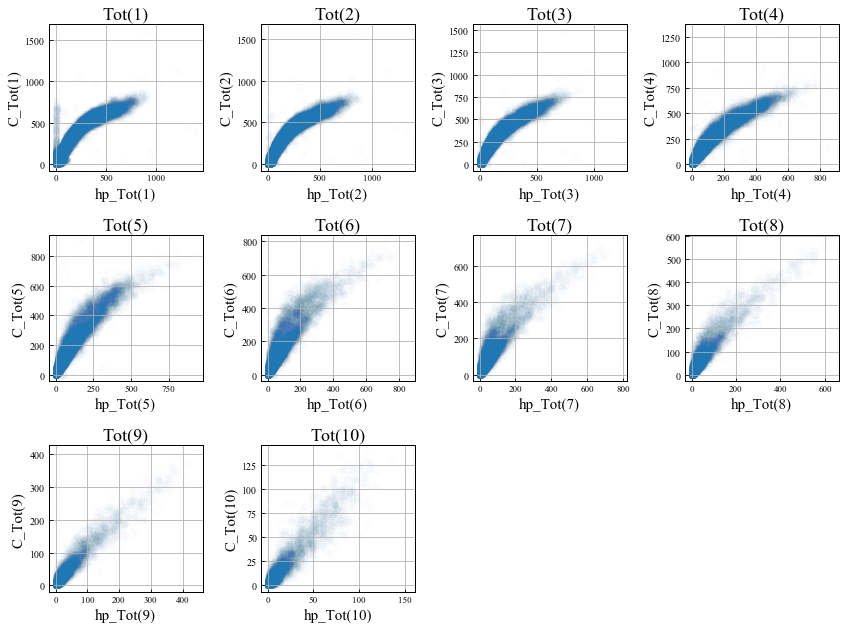

In [16]:
dispgraphs.scatter_graphs(df=df_2018, list_y_names=names_of_C, list_x_names=names_of_center,figsize=(3*4, 3*3), alpha=0.01)

## スロットごとに差分を引いていく（Method2に変換）

In [17]:
def make_dataframe_diff_of_slots(df):
    # name[1]にはスロット１のデータ、name[2]には、スロット２のデータ、name[3]に、、、が入っている
    names = [0]*10
    for j in range(1, 11):
        names[j-1] = [i for i in df.columns if '({})'.format(j) in i]
    # （スロット１のデータ）−（スロット２のデータ）、（スロット２のデータ）－（スロット３のデータ）、、、としていき、
    # 粒径ごとのデータに分類する
    df_dia = [0]*10
    for i in range(1, 10):
        df_dia[i-1] = df[names[i-1]] - df[names[i]].values
    df_dia[9] = df[names[-1]]

    # 全てのデータを繋げる
    df_dia_all = pd.DataFrame()
    for i in range(1, 10):
        df_dia_all = pd.concat([df_dia_all, df_dia[i-1]], axis=1)
    df_dia_all = pd.concat([df_dia_all, df_dia[-1]], axis=1)
    
    df_dia_all['Load_Avg'] = df['Load_Avg']
    df_dia_all['Load_Avg_difference'] = df['Load_Avg_difference']
    
    #'WL_FMR_Avg'と'WaterLevel(cm)'は違う計測器で水深を測っているよう（要確認）で、
    #scatter graphで見ると値が１：１になった。そのため、'WL_FMR_Avg'を使っている。
    df_dia_all['WaterLevel(cm)'] = df['WL_FMR_Avg']

    return df_dia_all

df_2018_dia = make_dataframe_diff_of_slots(df_2018)
df_2017_dia = make_dataframe_diff_of_slots(df_2017)    

飽和の影響で特に早く飽和するhpの値がTot1ではマイナスになっている。例えばTot３の右下のもやっとした領域はhpが飽和してCでは飽和していないときのデータであると考えられる。

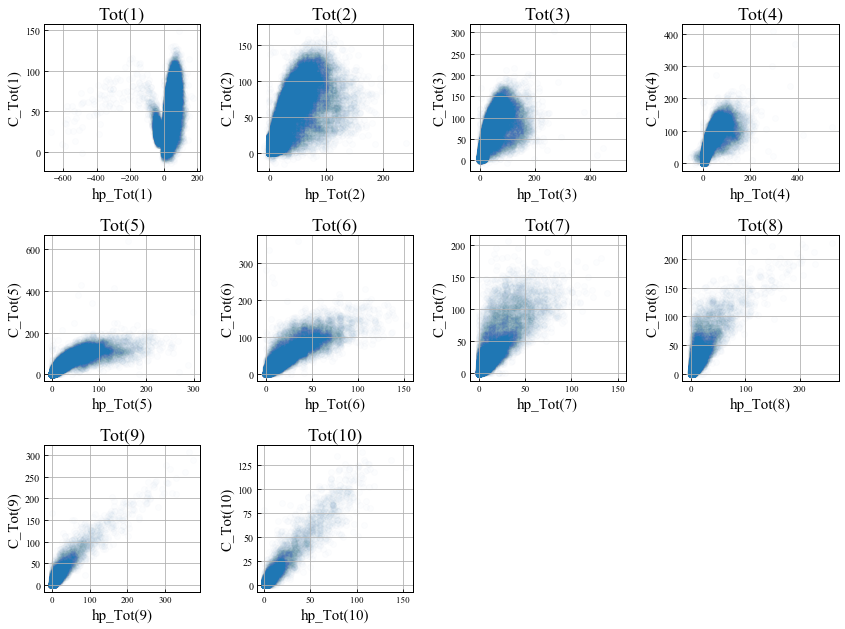

In [18]:
dispgraphs.scatter_graphs(df=df_2018_dia, list_y_names=names_of_C, list_x_names=names_of_center,figsize=(3*4, 3*3), alpha=0.01)

## 2018年と2017年のピット内変化をグラフ表示

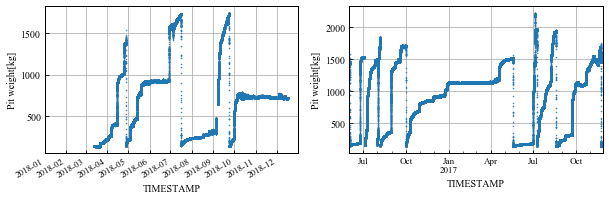

In [19]:
def graph_pit_time_series_2017_2018():
    %matplotlib inline
    plt.figure(figsize=(10, 3))
    plt.rcParams['font.family'] = 'Times New Roman'
    plt.subplot(121)
    df_2018['Load_Avg'].plot(ls='none', marker='.', markersize=1)
    plt.ylabel('Pit weight[kg]')
    plt.subplot(122)
    df_2017['Load_Avg'].plot(ls='none', marker='.', markersize=1)
    plt.ylabel('Pit weight[kg]')

graph_pit_time_series_2017_2018()

## 2018年データ整理

In [20]:
# 2018年データの整理
# 4/28、7/26 9/4-6 9/23にピット掃除をしていそうだったのでデータを全部削除
# データに異常がみられる3/26,4/18を削除
# イベントがなく、じわじわピット内流砂が減少していた10/4以降を削除
sidxs = []
eidxs = []

sidxs.append('2018-04-28 0:00')
eidxs.append('2018-04-29 0:00')

sidxs.append('2018-07-16 0:00')
eidxs.append('2018-07-17 0:00')

sidxs.append('2018-09-04 0:00')
eidxs.append('2018-09-06 0:00')

sidxs.append('2018-09-23 0:00')
eidxs.append('2018-09-24 0:00')

sidxs.append('2018-03-26 0:00')
eidxs.append('2018-03-27 0:00')

sidxs.append('2018-04-18 0:00')
eidxs.append('2018-04-19 0:00')

sidxs.append('2018-10-04 0:00')
eidxs.append(df_2018.index[-1])


#df_dia_all_2018とdf_2018両方から削除
for sidx, eidx in zip(sidxs, eidxs):
    drop_date_range = pd.date_range(sidx, eidx, freq='min')
    drop_date_range = drop_date_range & df_2018.index
    df_2018 = df_2018.drop(drop_date_range)
    df_2018_dia = df_2018_dia.drop(drop_date_range)


# # ピット差分が１０以上で、水平ハイドロフォンの６４倍が０のデータは全て消しました。（経験上。もっと良いエラー値削除法があれば、、）
# df_2018 = df_2018[~((df_2018['Load_Avg_difference'] >= 10)
#                   & (df_2018['hp_Tot(6)'] <= 3))]
# #
# df_2018_dia = df_2018_dia[~(
#     (df_2018_dia['Load_Avg_difference'] >= 10) & (df_2018_dia['hp_Tot(6)'] <= 3))]

## 2017年データ整理

In [21]:
# ２０１７年データの整理
# ピット掃除をしていそうだったのでデータを全部削除
sidxs = []
eidxs = []

sidxs.append("2016-10-1 0:00")
eidxs.append('2016-10-2 0:00')

sidxs.append("2017-11-23 0:00")
eidxs.append('2017-12-24 0:00')

sidxs.append("2017-5-19 0:00")
eidxs.append('2017-05-20 0:00')

sidxs.append("2017-07-08 0:00")
eidxs.append('2017-07-09 0:00')
        
sidxs.append("2017-8-19 0:00")
eidxs.append('2017-08-20 0:00')

sidxs.append(df_2017.index[0])
eidxs.append("2016-06-3 0:00")
  
    
# sidxs.append('2018-10-04 0:00')
# eidxs.append(df_all.index[-1])


for sidx, eidx in zip(sidxs, eidxs):
    drop_date_range = pd.date_range(sidx, eidx, freq='min')
    drop_date_range = drop_date_range & df_2017.index
    df_2017 = df_2017.drop(drop_date_range)
    df_2017_dia = df_2017_dia.drop(drop_date_range)

# # Cut data where pit weigh < 1000?500?
# df_2017['Load_Avg'] = df_2017['Load_Avg'].values.astype('float')
# # df_2017 = df_2017[(df_2017['Load_Avg'] > 200)&(df_2017['Load_Avg'] < 1300)]

# # Cut data where pit load difference is out of margin of error
# df_2017 = df_2017[(df_2017['Load_Avg_difference'] < 20) &
#                   (df_2017['Load_Avg_difference'] > -0.5)]

# df_2017 = df_2017[~((df_2017['Load_Avg_difference'] > 5)
#                     & (df_2017['hp_Tot(6)'] < 50))]

# # ピット差分が１０以上で、水平ハイドロフォンの６４倍が1０以下のデータは全て消しました。
# df_2017 = df_2017[~((df_2017['Load_Avg_difference'] >= 10)
#                     & (df_2017['hp_Tot(6)'] <= 10))]

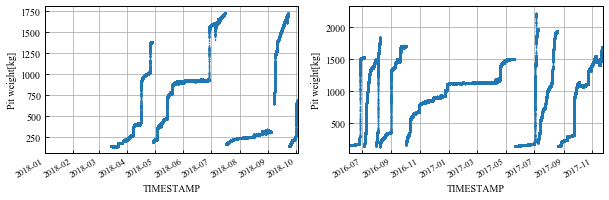

In [22]:
graph_pit_time_series_2017_2018()

## 30分平均にする

In [23]:
#dfを３０分間隔平均にする。（'Load_Avg'と'Load_Avg_difference'は平均間隔にするとおかしくなるのでしない）
def mean_of_df(df):
    sum_interval = 30
    df_mean = df.resample('{}T'.format(sum_interval)).sum() / sum_interval
    df_mean['Load_Avg'] = df['Load_Avg']
    df_mean['Load_Avg_difference'] = df['Load_Avg_difference'].resample(
        '{}T'.format(sum_interval)).sum() / sum_interval
    print(min(df_mean['Load_Avg_difference'])) #to check if there's difference btw mean and dia_mean
    return df_mean

df_2018_mean = mean_of_df(df_2018)
df_2018_dia_mean = mean_of_df(df_2018_dia)
df_2017_mean = mean_of_df(df_2017)
df_2017_dia_mean = mean_of_df(df_2017_dia)


-3.066666666666667
-3.066666666666667
-12.466666666666667
-12.466666666666667


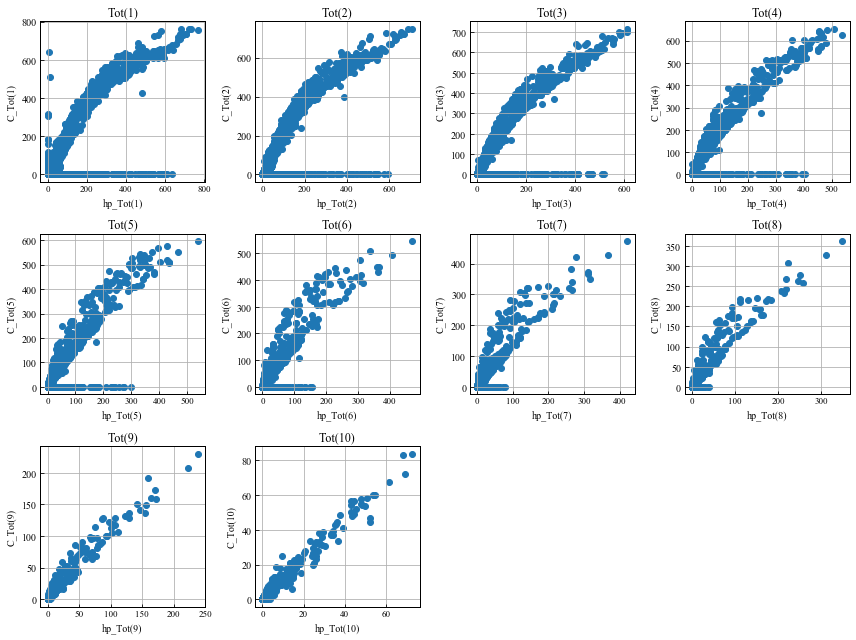

In [25]:
dispgraphs.scatter_graphs(df=df_2018_mean, list_y_names=names_of_C, list_x_names=names_of_center,figsize=(3*4, 3*3))

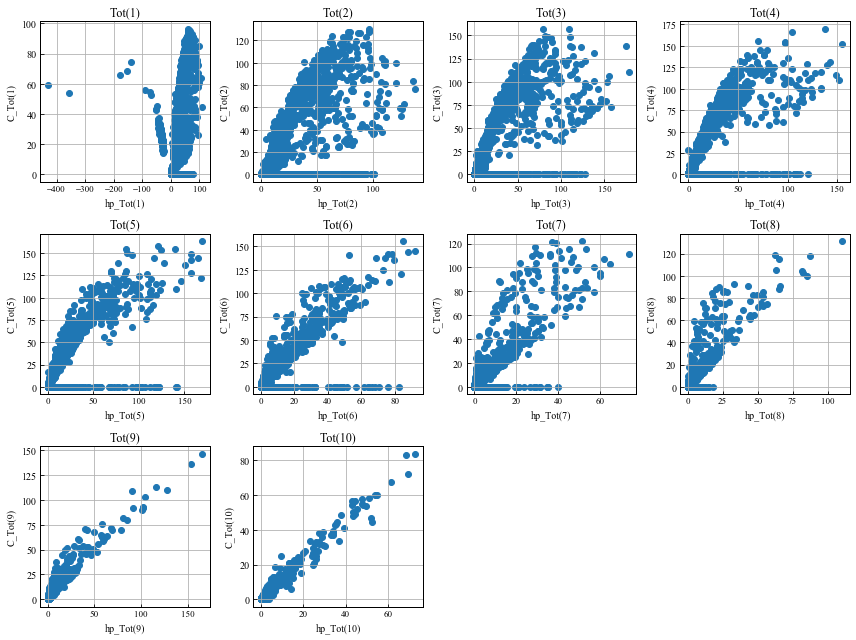

In [26]:
dispgraphs.scatter_graphs(df=df_2018_dia_mean, list_y_names=names_of_C, list_x_names=names_of_center,figsize=(3*4, 3*3))

## 流砂量が一定以上の時の水深と流速

In [27]:
#'Load_Avg_difference>4の水深（'Water level'）'
print(df_2017_mean.columns)

Index(['Unnamed: 0', 'RECORD', 'Bat_Avg', 'Pit_WL_Avg', 'L_UR_Avg', 'L_UL_Avg',
       'L_DR_Avg', 'L_DL_Avg', 'Load_Avg', 'Load_Avg_difference', 'WL_up_Avg',
       'WL_cha_Avg', 'turb1000_Avg', 'turb4000_Avg', 'DiffVolt_Avg',
       'hp_Tot(1)', 'hp_Tot(2)', 'hp_Tot(3)', 'hp_Tot(4)', 'hp_Tot(5)',
       'hp_Tot(6)', 'vel_P_Tot', 'WL_FMR_Avg', 'hp_Tot(7)', 'hp_Tot(8)',
       'hp_Tot(9)', 'hp_Tot(10)'],
      dtype='object')


In [28]:
water_level_when_big_BD_2018 = pd.DataFrame()
water_level_when_big_BD_2018['Velocity(m/s)'] = df_2018_mean['Velocity(m/s)'][df_2018_mean['Load_Avg_difference']>1]

In [29]:
water_level_when_big_BD_2018.head()

,Velocity(m/s)
TIMESTAMP,
2018-04-15 06:30:00,3.077000
2018-04-15 09:00:00,3.245000
2018-04-15 10:30:00,3.342333
2018-04-15 11:00:00,3.375333
2018-04-15 11:30:00,3.325000


水深はせいぜい2倍程度の違いになることがわかる。
ハイドロフォンの音の大きさは運動量に比例することが示されてる。では2倍程度の違いがどのくらい影響を与えるか調べてみる。

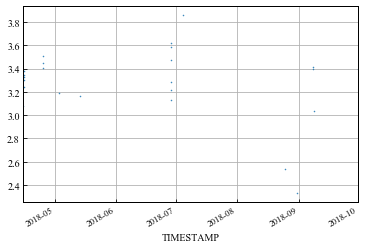

In [30]:
dispgraphs.time_series_graph(water_level_when_big_BD_2018, col_name='Velocity(m/s)')

(array([1., 0., 1., 0., 0., 0., 0., 0., 0., 2., 2., 3., 2., 4., 4., 2., 2.,
        0., 0., 1.]),
 array([2.32833333, 2.40478333, 2.48123333, 2.55768333, 2.63413333,
        2.71058333, 2.78703333, 2.86348333, 2.93993333, 3.01638333,
        3.09283333, 3.16928333, 3.24573333, 3.32218333, 3.39863333,
        3.47508333, 3.55153333, 3.62798333, 3.70443333, 3.78088333,
        3.85733333]),
 <a list of 20 Patch objects>)

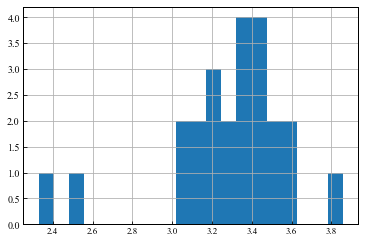

In [31]:
plt.hist(water_level_when_big_BD_2018['Velocity(m/s)'], 20)

違う計測器で測った流速だが、2017年はこのようになった。いくつかの外れ値はあるが、基本的に1.5倍スケールの中に入っている

(array([1., 0., 0., 1., 0., 0., 2., 1., 0., 0., 0., 1., 1., 5., 7., 7., 1.,
        0., 0., 1.]),
 array([1.1011    , 1.20808667, 1.31507333, 1.42206   , 1.52904667,
        1.63603333, 1.74302   , 1.85000667, 1.95699333, 2.06398   ,
        2.17096667, 2.27795333, 2.38494   , 2.49192667, 2.59891333,
        2.7059    , 2.81288667, 2.91987333, 3.02686   , 3.13384667,
        3.24083333]),
 <a list of 20 Patch objects>)

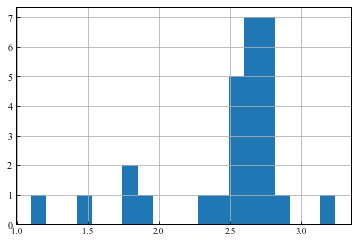

In [32]:
water_level_when_big_BD_2017 = pd.DataFrame()
water_level_when_big_BD_2017['Velocity(m/s)'] = df_2017_mean['vel_P_Tot'][df_2017_mean['Load_Avg_difference']>2]
plt.hist(water_level_when_big_BD_2017['Velocity(m/s)'], 20)

num_ampで倍率を変えれる。0-9が倍率1024-2に対応
縦軸運動量、青が最小の運動量、オレンジが最大の運動量、赤が閾値(勝手に決めた)

倍率： [1024, 512, 256, 128, 64, 32, 16, 8, 4, 2]


(0.0009, 0.36000000000000004)

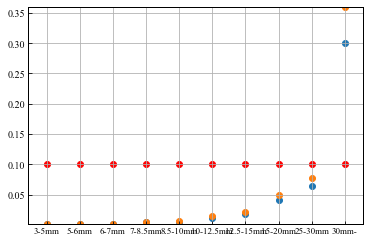

In [33]:
amplification_factor_values = [int(x) for x in amplification_factor.values()]
print("倍率：", amplification_factor_values)

num_amp = 9
threshold = 0.1

lowest_momentum = W_IDEAL*3
highest_momentum = W_IDEAL*3.6


lowest_waves = []
for i in range(len(amplification_factor_values)):
    lowest_waves.append(lowest_momentum*amplification_factor_values[i])
    
highest_waves = []
for i in range(len(amplification_factor_values)):
    highest_waves.append(highest_momentum*amplification_factor_values[i])

plt.scatter(TARGET_TOT[1:], lowest_waves[num_amp])
plt.scatter(TARGET_TOT[1:], highest_waves[num_amp])
plt.scatter(TARGET_TOT[1:], [threshold]*10, c='r')
# plt.yscale('log')
plt.ylim(min(lowest_waves[num_amp]), max(highest_waves[num_amp]))

## 流砂量が一定以下の時の水深と流速

# 代表イベント

## 3つのイベントを抽出、df_2018_dia_mean_eventsに格納

In [34]:
NUM_OF_EVENTS = 3
df_2018_dia_mean_events = [0]*NUM_OF_EVENTS
df_2018_dia_mean_events[0] = df_2018_dia_mean['2018-04-15 0:00': '2018-04-16 0:00']
df_2018_dia_mean_events[1] = df_2018_dia_mean['2018-09-08 0:00': '2018-09-08 8:00']
# df_2018_dia_mean_events[1] = df_2018_dia_mean['2018-09-08 0:00': '2018-09-16 12:00']
df_2018_dia_mean_events[2] = df_2018_dia_mean['2018-09-30 21:00': '2018-10-1 6:00']

event_color_2018_dia_mean_events = ['b', 'g', 'r']

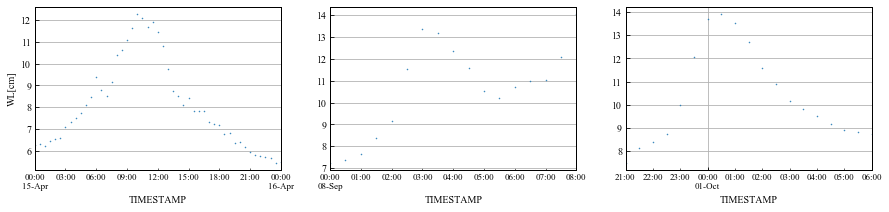

In [35]:
def graph_pit_time_series_WL():
    %matplotlib inline
    plt.figure(figsize=(15, 3))
    plt.rcParams['font.family'] = 'Times New Roman'
    plt.subplot(131)
    df_2018_mean['WaterLevel(cm)']['2018-04-15 0:00': '2018-04-16 0:00'].plot(ls='none', marker='.', markersize=1)
    plt.ylabel('WL[cm]')

    plt.subplot(132)
    df_2018_mean['WaterLevel(cm)']['2018-09-08 0:00': '2018-09-08 8:00'].plot(ls='none', marker='.', markersize=1)

    plt.subplot(133)
    df_2018_mean['WaterLevel(cm)']['2018-09-30 21:00': '2018-10-1 6:00'].plot(ls='none', marker='.', markersize=1)

    
    
graph_pit_time_series_WL()

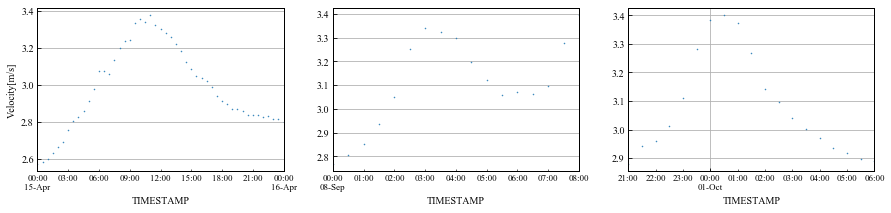

In [36]:
def graph_pit_time_series_Velocity():
    %matplotlib inline
    plt.figure(figsize=(15, 3))
    plt.rcParams['font.family'] = 'Times New Roman'
    plt.subplot(131)
    df_2018_mean['Velocity(m/s)']['2018-04-15 0:00': '2018-04-16 0:00'].plot(ls='none', marker='.', markersize=1)
    plt.ylabel('Velocity[m/s]')

    plt.subplot(132)
    df_2018_mean['Velocity(m/s)']['2018-09-08 0:00': '2018-09-08 8:00'].plot(ls='none', marker='.', markersize=1)

    plt.subplot(133)
    df_2018_mean['Velocity(m/s)']['2018-09-30 21:00': '2018-10-1 6:00'].plot(ls='none', marker='.', markersize=1)

    
    
graph_pit_time_series_Velocity()

## 3つのイベントのピット変化、差分表示

In [37]:
#list内のdfの数だけ、グラフを並べる。colnameを指定。
def graphs_time_series_in_df_events(df_events, column_name='Load_Avg'):
    num_of_events = len(df_events)
    
    fig = plt.figure(figsize=(3*num_of_events, 3))
    for i in range(1, num_of_events+1):
        ax = plt.subplot(130+i)
        ax.set_title('event_no{}'.format(i))
        ax.plot(df_events[i-1][column_name], color=event_color_2018_dia_mean_events[i-1])

        # x-Axis locations of 5 timestamps
        ts_loc = pd.to_datetime(np.linspace(
            df_events[i-1].index[0].value, df_events[i-1].index[-1].value, 5))
        f = "%m-%d %H:%M"
        ts_loc_without_year = ts_loc.strftime(f)
        ax.set_xticks(ts_loc, minor=False)

        # Names of the timestamps (only last shown)
        ts_names = ts_loc_without_year
        ax.set_xticklabels(ts_names, rotation="vertical")
        
        if column_name == 'Load_Avg':
            plt.ylabel('Pit weight[kg]')
        elif 'Load_Avg_difference' in column_name:
            plt.ylabel('Bedload discharge[kg m-1 min-1]')
        elif 'Tot' in column_name:
            slot_num = re.sub("\\D", "", column_name)
            num_of_amplification = amplification_factor['Tot('+ slot_num+ ')']
            plt.ylabel('Pusles[m-1 min-1]' + '(' + num_of_amplification + ')')
        else:
            plt.ylabel('Worning!Imputted Unknown data.')

    fig.tight_layout()
#     save_dir_seminers = './graphs_for_seminers/'
#     plt.savefig(os.path.join(save_dir_seminers, column_name +
#                              'pulses'))

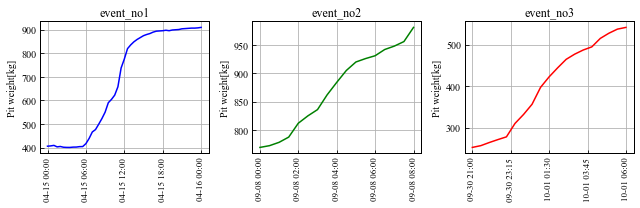

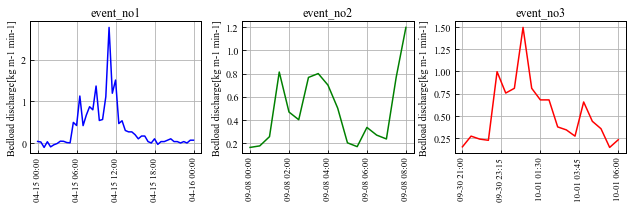

In [38]:
graphs_time_series_in_df_events(df_2018_dia_mean_events, column_name='Load_Avg')
graphs_time_series_in_df_events(df_2018_dia_mean_events, column_name='Load_Avg_difference')
# graphs_time_series_in_df_events(df_2018_dia_mean_events, column_name='hp_Tot(1)')
# graphs_time_series_in_df_events(df_2018_dia_mean_events, column_name='hp_Tot(4)')
# graphs_time_series_in_df_events(df_2018_dia_mean_events, column_name='hp_Tot(10)')

## パルス数（dia）と流砂量の比較

In [39]:
def scatter_graphs_diapalses_and_sd(df_events, y_name, x_name):
    %matplotlib inline
    save_dir_seminers = './graphs_for_seminers/'
    slot_num = re.sub("\\D", "", y_name)
    num_of_amplification = amplification_factor['Tot('+ slot_num+ ')']
    num_of_events = len(df_events)
    
    y_max_val = 0
    x_max_val = 0
    for df in df_events:
        y_max_val = max(max(df[y_name]), y_max_val)
        x_max_val = max(max(df[x_name]), x_max_val)

    fig = plt.figure(figsize=(9, 6))
    fig.suptitle(num_of_amplification, fontsize=16)
    ylim = y_max_val
    xlim = x_max_val
    margin = ylim/20

    for i in range(num_of_events):
        x = df_events[i][x_name]
        y = df_events[i][y_name]
        plt.subplot(231 + i)
        plt.title("event{0}".format(i+1))
        plt.scatter(x, y, marker='.', color=event_color_2018_dia_mean_events[i])
        plt.xlim(-1, xlim+0.5)
        plt.ylim(-margin, ylim + margin)
        plt.ylabel('Pusles[m-1 min-1]' + '(' + num_of_amplification + ')')
        plt.xlabel('Bedload discharge[kg m-1 min-1]')

    plt.subplot(236)
    plt.title("event1-3")
    for i in range(num_of_events):
        x = df_events[i][x_name]
        y = df_events[i][y_name]
        plt.scatter(x, y, marker='.', color=event_color_2018_dia_mean_events[i])
        plt.xlim(-1, xlim+0.5)
        plt.ylim(-margin, ylim + margin)
        plt.ylabel('Pusles[m-1 min-1]' + '(' + num_of_amplification + ')')
        plt.xlabel('Bedload discharge[kg m-1 min-1]')

    fig.tight_layout()
#     plt.savefig(os.path.join(save_dir_seminers, y_name + "2018_3events" +
#                              "_" + process + str(len(df_event_num)) + 'events'))

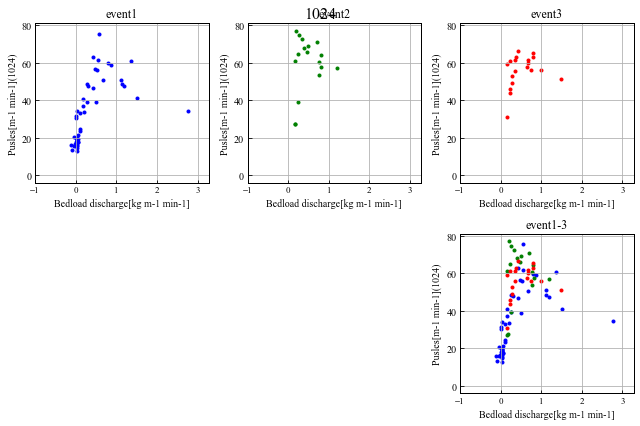

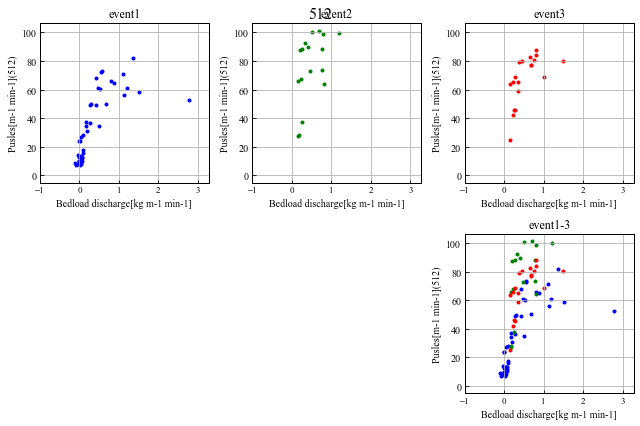

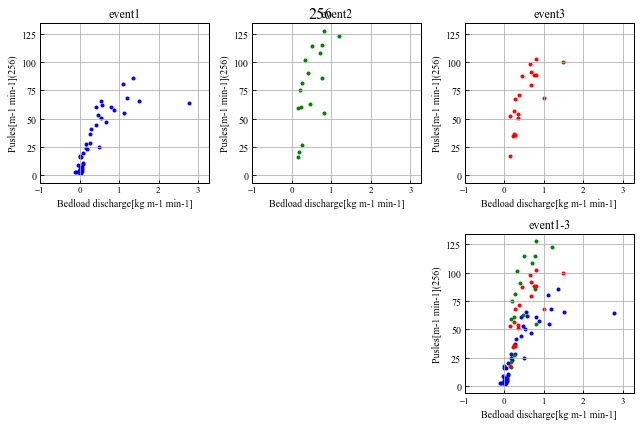

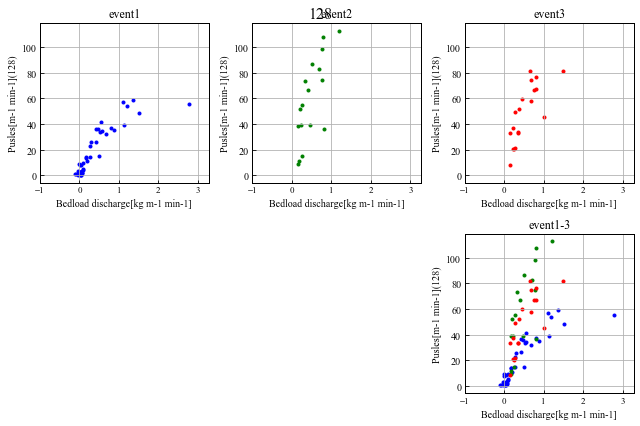

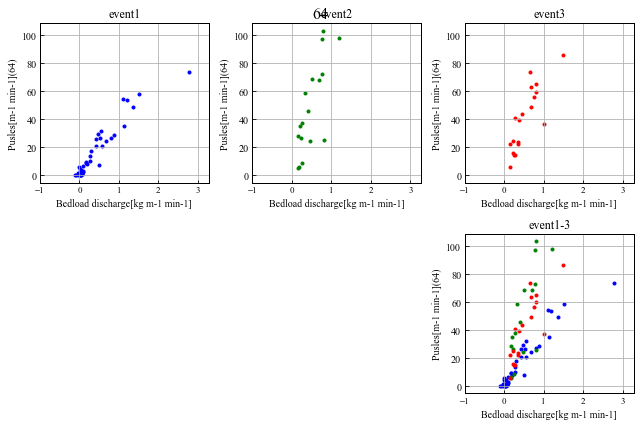

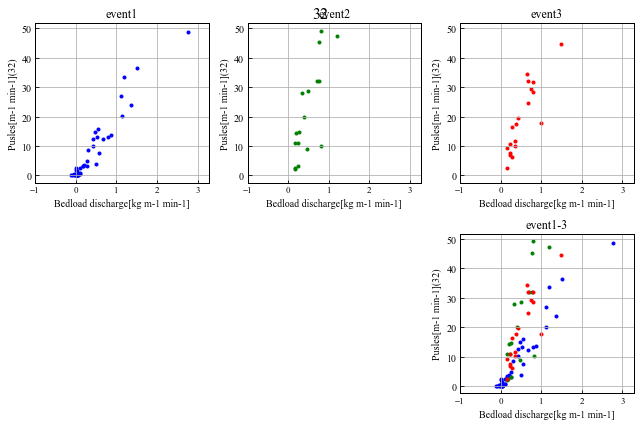

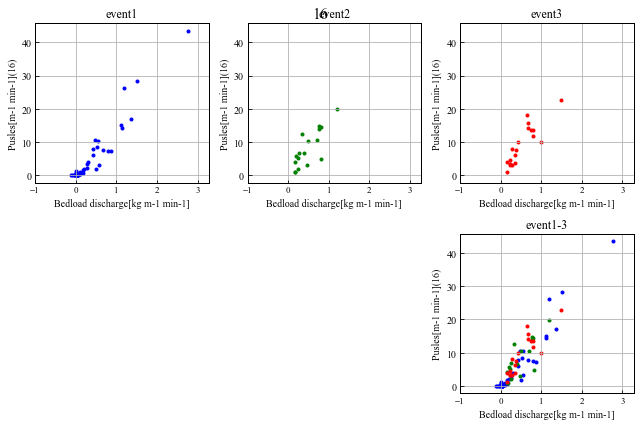

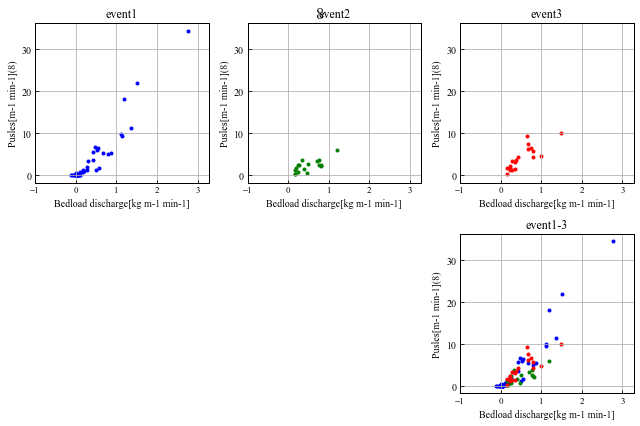

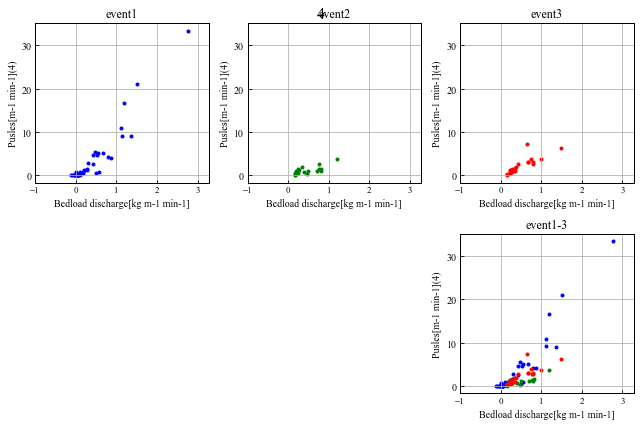

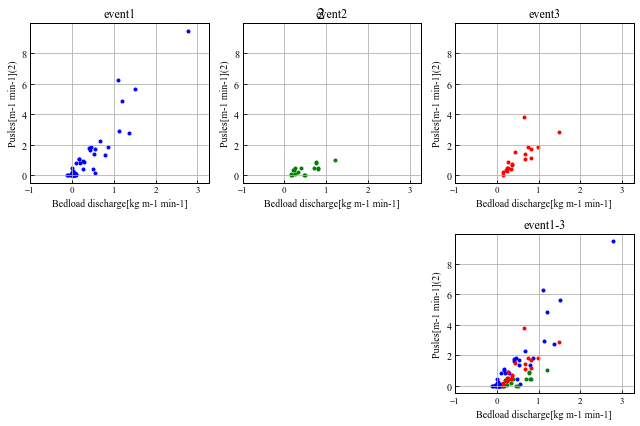

In [40]:
#中央直上ハイドロフォン
for y_name in names_of_center:
    scatter_graphs_diapalses_and_sd(df_2018_dia_mean_events, y_name=y_name, x_name='Load_Avg_difference')
#     plt.savefig(os.path.join(save_dir_seminers, y_name + 'events'))
    plt.show()

In [41]:
# #中央ハイドロフォン
# for y_name in names_of_C:
#     scatter_graphs_diapalses_and_sd(df_2018_dia_mean_events, y_name=y_name, x_name='Load_Avg_difference')
#     plt.show()

In [42]:
# #補正版中央ハイドロフォン
# #中央ハイドロフォン
# for y_name in names_of_LC_Corrected:
#     scatter_graphs_diapalses_and_sd(df_2018_dia_mean_events, y_name=y_name, x_name='Load_Avg_difference')
#     plt.show()

## 最小化問題を解く、Cを算出

In [43]:

# 目的関数
def func(Const):
    Cost = 0
    for i in range(NUM_OF_EVENTS):
        #Y:ピット流砂量
        Y = df_2018_dia_mean_events[i]['Load_Avg_difference'].values.reshape(len(df_2018_dia_mean_events[i]['Load_Avg_difference']),1)
        #パルス流砂量
        X = df_2018_dia_mean_events[i][names_of_center]
        Z = np.dot(X, W_ideal.reshape(1,10).T)
        Qcalc = Const*Z*(1 + Correction_factor_fine)
        A0 = np.abs(Qcalc-Y)
        A1 = np.power(A0,2)
        cost = np.sum(A1 ,axis=0, keepdims=True)
        Cost = Cost + cost[0][0]
    return Cost

def output_result_of_func():
    cons = ({'type': 'ineq', 'fun': lambda Const: Const})
    temp = []
    W_ans = []
    results = []
    Const0 = np.random.rand()# 初期値は適当
    result = minimize(func, x0=Const0, constraints=cons, method="SLSQP")
    Correction_factor = result.x[0]
    
    return Correction_factor

In [44]:
#実験から得られた理想値（W）を代入して流砂量算出

Correction_factor_fine = 0.763
W_ideal = np.array([0.15, 0.22, 0.29, 0.65, 0.91, 1.96, 3.01, 6.91, 10.81, 50])*0.001
Correction_factor = output_result_of_func()
print(Correction_factor)

def calc_Qcalc(df, list_of_hydrophone_names):
#     qbedload = np.dot(df[names_of_center], W_ideal.reshape(1,10).T)
#     qcalc_array = Correction_factor*qbedload*(1+Correction_factor_fine)
    qbedload_each_df= df[list_of_hydrophone_names]*W_ideal
    qbedloade_df = qbedload_each_df.sum(axis=1)
    qcalc_df = Correction_factor*(1+Correction_factor_fine)*qbedloade_df
    qcalc_df.columns = ['Qcalc']
    return qcalc_df


qcalc_2018_events = []
qobs_2018_events = []
for df in df_2018_dia_mean_events:
    qcalc_2018_events.append(calc_Qcalc(df, names_of_center))
    qobs_2018_events.append(df['Load_Avg_difference'])

qcalc_2018_events_concat = pd.concat(qcalc_2018_events)
qobs_2018_events_concat = pd.concat(qobs_2018_events)

1.0422461994895016


In [45]:
# 重み付き最小二乗法（単純な最小2乗法ではない）
def linear_regression(df_X, df_Y, color='r'):
    """
    X:input of x ax(example:x_cols)
    Y:input of y ax(example:x_cols)
    """
    # fit_intercept	False に設定すると切片を求める計算を含めない。
    # 目的変数が原点を必ず通る性質のデータを扱うときに利用。 (デフォルト値: True)
    clf = linear_model.LinearRegression(fit_intercept=False)

    X = df_X.values.reshape(-1, 1)
    Y = df_Y.values.reshape(-1, 1)
    clf.fit(X, Y)
    y_hat = clf.predict(X)

    # 近似直線との誤差を計算する
    diff = Y - y_hat

    # 近似直線との誤差が、比較的が大きい点を無視するような、sample_weightを作成する
    sample_weight = (np.max(np.abs(diff)) - np.abs(diff)
                     ).astype('float32').T[0] ** 2

    # scikit-learnのsolverに、sample_weightを与えて、近似直線を得る
    # 詳しくは"https://medium.com/micin-developers/decipher-github-lr-sw-40e519a13c0a"
    clf.fit(X, Y, sample_weight=sample_weight)
    
    label_slope = "slope:" + str(round(clf.coef_.flatten()[0], 2)) + \
        "\n" + "R^2:" + str(round(clf.score(X, Y), 2))

    # 回帰直線
    plt.plot(X, clf.predict(X), label=label_slope, c=color)
    plt.legend()

    return clf.coef_.flatten()[0]

0.9905547855209929

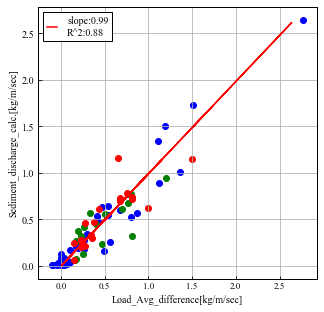

In [46]:
%matplotlib inline
plt.figure(figsize=(5,5))
for i, qcalc in enumerate(qcalc_2018_events):
#     qobs = df_2018_dia_mean_events[i]['Load_Avg_difference'].values.reshape(len(df_2018_dia_mean_events[i]['Load_Avg_difference']),1)
    qobs = df_2018_dia_mean_events[i]['Load_Avg_difference']
    plt.scatter(qobs, qcalc, color=event_color_2018_dia_mean_events[i])
plt.xlabel('Load_Avg_difference[kg/m/sec]')
plt.ylabel('Sediment_discharge_calc.[kg/m/sec]')

linear_regression(qcalc_2018_events_concat, qobs_2018_events_concat)

## calc.とobs.を比較

C:\Users\user\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


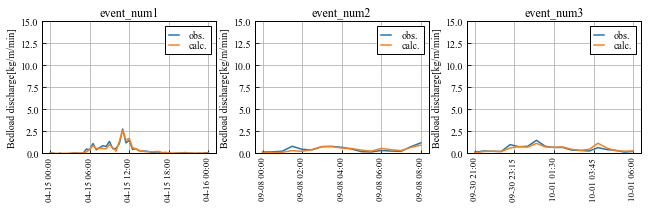

In [47]:
%matplotlib inline
fig = plt.figure(figsize=(9, 3))
for i, qcalc in enumerate(qcalc_2018_events):
    ax = plt.subplot(131+i)
    ax.set_title('event_num{}'.format(i+1))
    ax.plot(df_2018_dia_mean_events[i]['Load_Avg_difference'], label='obs.')
    ax.plot(qcalc, label='calc.')
    plt.legend()
    plt.ylabel('Bedload discharge[kg/m/min]')

    # x-Axis locations of 5 timestamps
    ts_loc = pd.to_datetime(np.linspace(qcalc.index[0].value, qcalc.index[-1].value, 5))
    f = "%m-%d %H:%M"
    ts_loc_without_year = ts_loc.strftime(f)
    ax.set_xticks(ts_loc, minor=False)

    # Names of the timestamps (only last shown)
    ts_names = ts_loc_without_year
    ax.set_xticklabels(ts_names, rotation="vertical")

    ax.set_ylim(0, 15)


fig.tight_layout()
# plt.savefig(os.path.join('comparison_of_Load_Avg_difference_btw_obs_and_calc_events'))
fig.show()

# 五本の水平ハイドロフォン

In [48]:
qcalc_2018_events_C = []
qcalc_2018_events_LC = []
qcalc_2018_events_RC = []
qcalc_2018_events_R = []
qcalc_2018_events_L = []

for df in df_2018_dia_mean_events:
    qcalc_2018_events_C.append(calc_Qcalc(df, names_of_C))
    qcalc_2018_events_LC.append(calc_Qcalc(df, names_of_LC))
    qcalc_2018_events_RC.append(calc_Qcalc(df, names_of_RC))
    qcalc_2018_events_R.append(calc_Qcalc(df, names_of_R))
    qcalc_2018_events_L.append(calc_Qcalc(df, names_of_L))


<IPython.core.display.Javascript object>


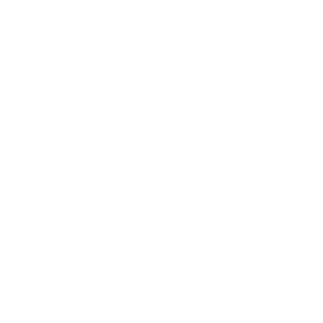

<IPython.core.display.Javascript object>


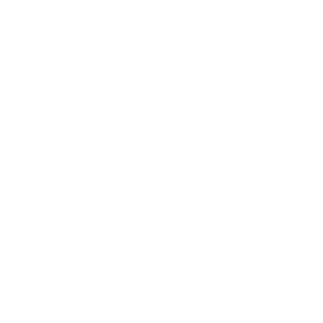

Traceback (most recent call last):
  File "C:\Users\user\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 215, in process
    func(*args, **kwargs)
  File "C:\Users\user\Anaconda3\lib\site-packages\matplotlib\animation.py", line 1478, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


In [49]:
save_dir_seminers = './graphs_for_seminers/' 
#event_num:0~2
event_num = 2
%matplotlib nbagg

fig = plt.figure(figsize = (5, 5))
ax = fig.add_subplot(111)

x = np.array(['R', 'RC', 'C', 'LC', 'L'])
max_ylim = max(qcalc_2018_events_C[event_num].max(), qcalc_2018_events_LC[event_num].max(),
               qcalc_2018_events_RC[event_num].max(), qcalc_2018_events_R[event_num].max(),
               qcalc_2018_events_L[event_num].max())
def update(i, fig_title, A):
    if i != 0:
        # 現在描写されているグラフを消去
        plt.cla()

    y = [qcalc_2018_events_R[event_num][i], qcalc_2018_events_RC[event_num][i], 
         qcalc_2018_events_C[event_num][i], qcalc_2018_events_LC[event_num][i], qcalc_2018_events_L[event_num][i]]
    ax.bar(x, y)
    ax.grid()
    
    ax.set_xlabel("x", fontsize = 15)
    ax.set_ylabel("Load_Avg_Difference", fontsize = 15)
    
    ax.set_ylim(0,max_ylim)

    ax.set_title(fig_title + ":" + str(qcalc_2018_events_C[event_num].index[i]))


ani = animation.FuncAnimation(fig, update, fargs = ('TIMESTAMP ', 2.0), \
    interval = 200, frames = len(qcalc_2018_events_C[event_num].index), repeat = False)

# ani.save(os.path.join(save_dir_seminers, 'animation_event'+ str(event_num) + 'events' + '.gif'), writer = 'imagemagick')

In [50]:
names_all = [names_of_R, names_of_RC, names_of_C, names_of_LC, names_of_L]

#全ての粒径毎の衝突回数に理想的Wを掛けた
list_of_qbedload_2018_each = []
# list_of_qcalc_2018 = []
# list_of_qfine_2018 = []

#list番号[0,1,2,3,4] = [R, RC, C, LC, L]
for i, name in enumerate(names_all):
    list_of_qbedload_2018_each.append(df_2018_dia_mean[name].mul(W_ideal.reshape(1,10)))
#     list_of_qfine_2018.append(Correction_factor*Correction_factor_fine*list_of_qbedload_2018[i])
#     list_of_qcalc_2018.append(Correction_factor*list_of_qbedload_2018[i] + list_of_qfine_2018[i])

In [51]:
#粒径別の重量をすべて足し合わせる(列方向)
def list_of_dfs_sumall_col(list_of_dfs, new_list_of_dfs):
    for df in list_of_dfs:
        new_list_of_dfs.append(df.sum(axis=1))

#粒径別の重量をすべて足し合わせる(行方向)
def list_of_dfs_sumall_row(list_of_dfs, new_list_of_dfs):
    for df in list_of_dfs:
        new_list_of_dfs.append(df.sum())



In [52]:
#beadloadの時間ごと合計を計算
list_of_qbedload_2018 = []
list_of_dfs_sumall_col(list_of_qbedload_2018_each, list_of_qbedload_2018)

#beadloadの粒径別の全データ堆積流砂量
list_of_qbedload_2018_cumulated = []
list_of_dfs_sumall_row(list_of_qbedload_2018_each, list_of_qbedload_2018_cumulated)

In [53]:
qbedload_2018_cumulated = []
for qbedload_all_Tot in list_of_qbedload_2018_cumulated:
    qbedload_2018_cumulated.append(Correction_factor* qbedload_all_Tot.sum())
    

qfine_2018_cumulated = list(map(lambda x: x * Correction_factor_fine*Correction_factor, qbedload_2018_cumulated))

print(qbedload_2018_cumulated)
print(qfine_2018_cumulated)


[187.41566378735612, 212.9263456768899, 613.8865158784522, 1382.579341146344, 1251.4663857744158]
[149.03927990337385, 169.32623768388282, 488.1833376143245, 1099.4738926812893, 995.2084323683947]


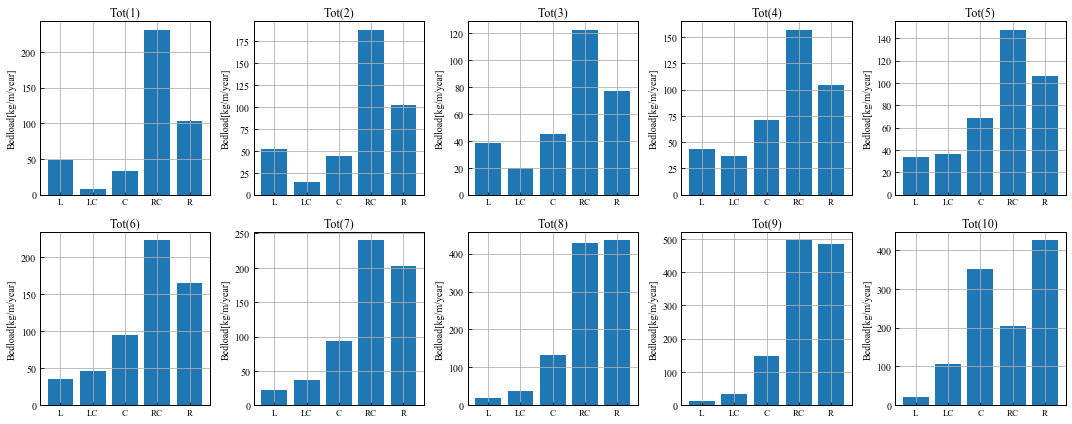

In [54]:
#sd_2018_dia_mean_Widealの可視化
def bar_chart(ax, y_list, x_list=['L','LC','C','RC','R']):
    x = np.array(x_list)
    y = np.array(y_list)
    ax.set_ylabel('Bedload[kg/m/year]')
    ax.bar(x, y)

def display_bar_charts(list_of_arraies):
    num_of_tots = len(list_of_arraies)    
    %matplotlib inline
    fig = plt.figure(figsize=(3*5, 6))
    for i, y_list in enumerate(list_of_arraies):
        ax = plt.subplot(2, 5, i+1)
        bar_chart(ax, y_list)
        ax.set_title('Tot({})'.format(i+1))

    fig.tight_layout()

#list番号[0,1,2,3,,,,9] = [Tot(1), Tot(2), Tot(3),....Tot(10)]
#空のリスト作成
list_of_Tots = [[] for i in range(10)]
for tot_num in range(10):
    for sd in list_of_qbedload_2018_cumulated:
        corrected_sd = list(map(lambda x: x * Correction_factor*(1+ Correction_factor_fine), sd))
        list_of_Tots[tot_num].append(corrected_sd[tot_num])
        
#     plt.savefig(os.path.join(save_dir_seminers, "Bedload_year" +
#                              y_name + process + str(len(df_event_num)) + 'events'))

display_bar_charts(list_of_Tots)

In [55]:
# sd_2018_dia_year = []
# for i in range(5):
#     sd_2018_dia_year.append(list_of_dfs_2018_dia_mean_Wideal_sumall[i].sum())


[47.947728098685715, 8.112970539038912, 33.30959028115462, 231.05324898190722, 102.61354050628148]
[52.490255016044976, 14.847496619433779, 43.66686691531083, 187.87406397162763, 101.9482502296203]
[38.24773584061444, 19.896519400052433, 45.02817687249126, 122.6732961215094, 77.37065607898121]
[43.65580344793155, 36.765847380106145, 71.0564192603274, 157.1043513139446, 104.79842065911153]
[33.92481841386189, 36.28226611805269, 68.65079895416687, 147.79741257582427, 106.0405571727082]
[36.006565711448694, 46.44516002520381, 94.54327055362431, 222.61938337696137, 165.45915688977712]
[22.64241896165691, 36.3864941114052, 93.36697768763482, 239.95809379823183, 202.83452641454417]
[20.45950185001329, 37.21613901609908, 132.94041802201485, 427.7200200373829, 435.45290844063226]
[13.488409400619878, 33.2237824128069, 149.10677819698427, 495.4838612466209, 484.6610878290627]
[21.550578516231425, 106.21247180615785, 350.6126307500017, 205.20364701699387, 425.1561338995758]



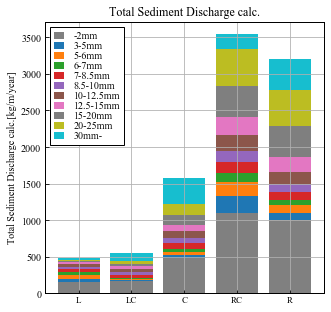

In [56]:
def python_list_add(in1, in2):
    wrk = np.array(in1) + np.array(in2)
    return wrk.tolist()

def display_stacked_barplot(list_of_arraies):
    num_of_tots = len(list_of_arraies)    
    %matplotlib inline
    fig = plt.figure(figsize=(5, 5))
    
    # Names of group and bar width
    names = ['L','LC','C','RC','R']
    legend = ['-2mm', '3-5mm', '5-6mm', '6-7mm', '7-8.5mm', '8.5-10mm', '10-12.5mm', '12.5-15mm', '15-20mm', '20-25mm', '30mm-']
    barWidth = 1

    # The position of the bars on the x-axis
    pre_ylist = []
    ax = plt.subplot(1, 1, 1)
    for i, y_list in enumerate(list_of_arraies):
        if i == 0:
            ax.bar(names, qfine_2018_cumulated, color='gray', label=legend[0])
            ax.bar(names, y_list, bottom=qfine_2018_cumulated, label=legend[1])
            print(y_list)
            pre_ylist = python_list_add(y_list, qfine_2018_cumulated)
        else:
            ax.bar(names, y_list, bottom=pre_ylist, label=legend[i+1])
            print(y_list)
            pre_ylist = python_list_add(pre_ylist, y_list)

    ax.set_title('Total Sediment Discharge calc.')
    ax.set_ylabel('Total Sediment Discharge calc.[kg/m/year]')
    ax.legend()
    
    print()
    


display_stacked_barplot(list_of_Tots)

In [57]:
#季節ごとに分けて上の図の分布を調べてみる
#list_of_dfs_2018_dia_mean_Widealを区切る(終わりと始まり指定)
def cut_list_of_dfs(start, end, list_of_dfs, new_list_of_dfs):
    for df in list_of_dfs:
        new_list_of_dfs.append(df[start:end])

[24.85743184941847, 12.212971829953414, 63.34438777488739, 151.74729977058428, 232.41797516399959]
[19.767471235957906, 9.712168610846103, 50.37360137944997, 120.67458945560709, 184.82664124779336]
[28.56342392207001, 10.778669593892724, 59.25256222680729, 179.3517034983003, 213.24858053374734]


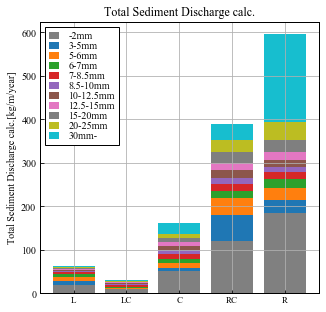

In [58]:
list_of_qbedload_2018_each_Spring = []
cut_list_of_dfs('2018-01-01 00:00', '2018-05-01 00:00', list_of_qbedload_2018_each, list_of_qbedload_2018_each_Spring)

#粒径別の堆積流砂量の分布をみる
list_of_qbedload_2018_Spring = []
list_of_dfs_sumall_col(list_of_qbedload_2018_each_Spring, list_of_qbedload_2018_Spring)

#粒径別の堆積流砂量の分布をみる
#sediment discharge
list_of_qbedload_2018_cumulated_Spring = []
list_of_dfs_sumall_row(list_of_qbedload_2018_each_Spring, list_of_qbedload_2018_cumulated_Spring)

#list番号[0,1,2,3,,,,9] = [Tot(1), Tot(2), Tot(3),....Tot(10)]
#空のリスト作成
list_of_Tots_Spring = [[] for i in range(10)]
for tot_num in range(10):
    for sd in list_of_qbedload_2018_cumulated_Spring:
        corrected_sd = list(map(lambda x: x * Correction_factor*(1+ Correction_factor_fine), sd))
        list_of_Tots_Spring[tot_num].append(corrected_sd[tot_num])
    
qbedload_2018_cumulated_Spring = []
for qbedload_all_Tot in list_of_qbedload_2018_cumulated_Spring:
    qbedload_2018_cumulated_Spring.append(Correction_factor* qbedload_all_Tot.sum())
    

qfine_2018_cumulated_Spring = list(map(lambda x: x * Correction_factor_fine*Correction_factor, qbedload_2018_cumulated_Spring))

print(qbedload_2018_cumulated_Spring)
print(qfine_2018_cumulated_Spring)

def display_stacked_barplot_Spring(list_of_arraies):
    num_of_tots = len(list_of_arraies)    
    %matplotlib inline
    fig = plt.figure(figsize=(5, 5))
    
    # Names of group and bar width
    names = ['L','LC','C','RC','R']
    legend = ['-2mm', '3-5mm', '5-6mm', '6-7mm', '7-8.5mm', '8.5-10mm', '10-12.5mm', '12.5-15mm', '15-20mm', '20-25mm', '30mm-']
    barWidth = 1

    # The position of the bars on the x-axis
    pre_ylist = []
    ax = plt.subplot(1, 1, 1)
    for i, y_list in enumerate(list_of_arraies):
        if i == 0:
            ax.bar(names, qfine_2018_cumulated_Spring, color='gray', label=legend[0])
            ax.bar(names, y_list, bottom=qfine_2018_cumulated_Spring, label=legend[1])
            pre_ylist = python_list_add(y_list, qfine_2018_cumulated_Spring)
            print(pre_ylist)
        else:
            ax.bar(names, y_list, bottom=pre_ylist, label=legend[i+1])
            pre_ylist = python_list_add(pre_ylist, y_list)

    ax.set_title('Total Sediment Discharge calc.')
    ax.set_ylabel('Total Sediment Discharge calc.[kg/m/year]')
    ax.legend()
    
display_stacked_barplot_Spring(list_of_Tots_Spring)


# ２０１７年データ 

## ピット200以下1000以上消す

In [59]:
df_2017_dia_mean_dropped = drop_untrusted_pit_data(df_2017_dia_mean, min_pit=200, max_pit=1000)
df_2018_dia_mean_dropped = drop_untrusted_pit_data(df_2018_dia_mean, min_pit=200, max_pit=1000)

df_2017_mean_dropped = drop_untrusted_pit_data(df_2017_mean, min_pit=200, max_pit=1000)
df_2018_mean_dropped = drop_untrusted_pit_data(df_2018_mean, min_pit=200, max_pit=1000)


## ピット内増減確認

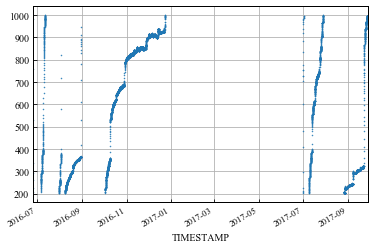

In [60]:
dispgraphs.time_series_graph(df_2017_dia_mean_dropped, col_name='Load_Avg')

## チャンネル毎の流砂量とパルス数の散文図一覧(1min毎)

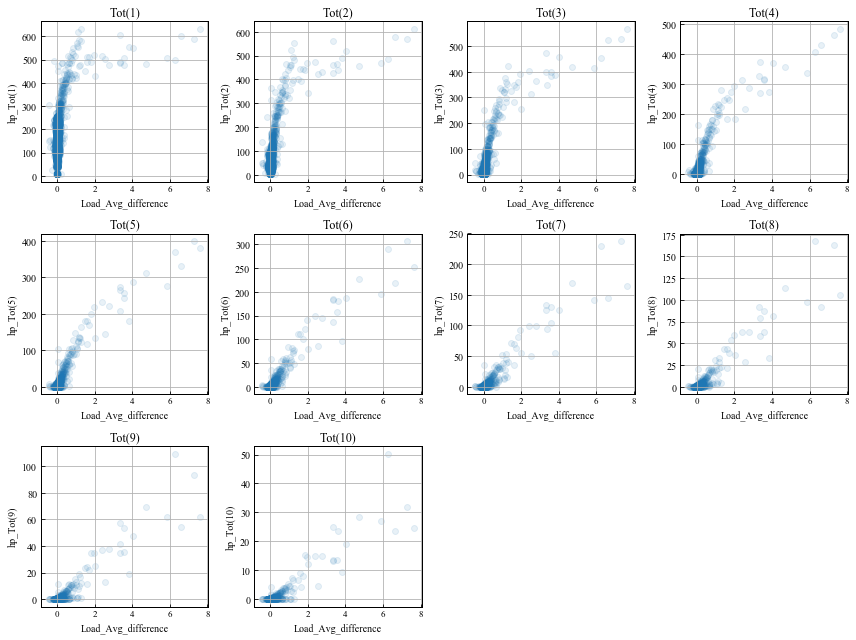

In [61]:
dispgraphs.scatter_graphs(df=df_2017_mean_dropped, list_y_names=names_of_center, list_x_names=['Load_Avg_difference']*10,
                                  figsize=(3*4, 3*3), alpha=0.1)

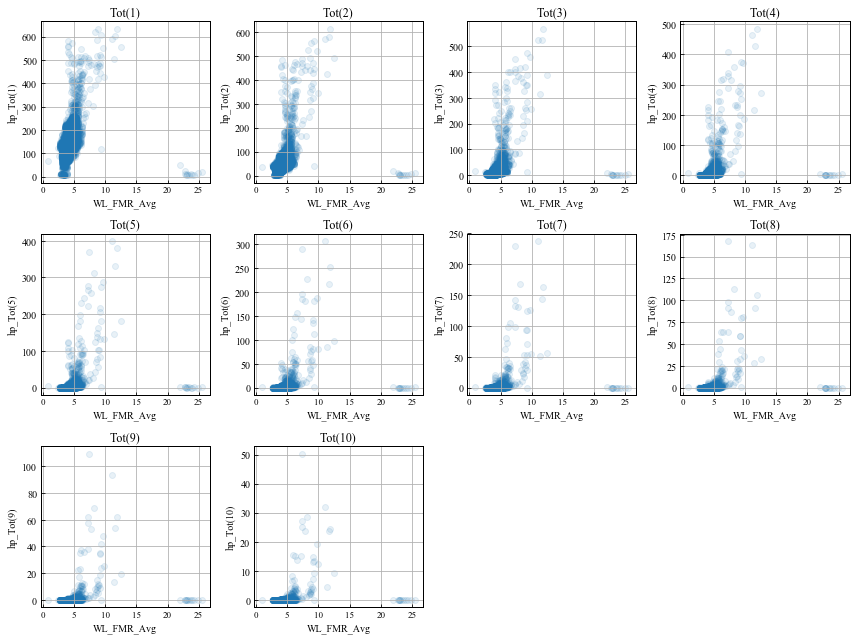

In [62]:
dispgraphs.scatter_graphs(df=df_2017_mean_dropped, list_y_names=names_of_center, list_x_names=['WL_FMR_Avg']*10,
                                  figsize=(3*4, 3*3), alpha=0.1)


## チャンネル毎の流砂量とパルス数の散文図一覧(30min毎)

下のグラフから、Tot(1)~(4)は使えないかも？パルスの飽和の影響。大粒径の流砂のみを対象にこの手法を用いればよいかも

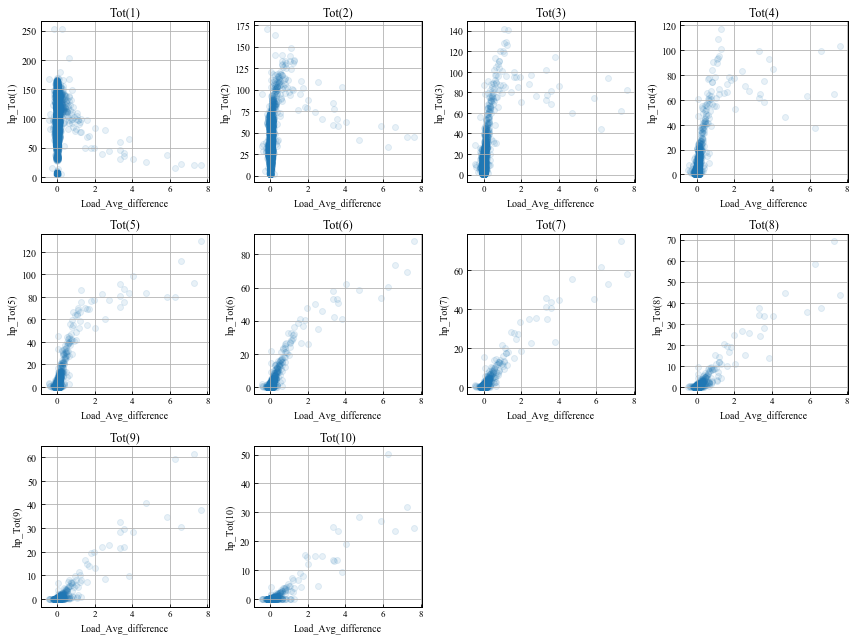

In [63]:
dispgraphs.scatter_graphs(df=df_2017_dia_mean_dropped, list_y_names=names_of_center,
                                  list_x_names=['Load_Avg_difference']*10, figsize=(3*4, 3*3), alpha=0.1)

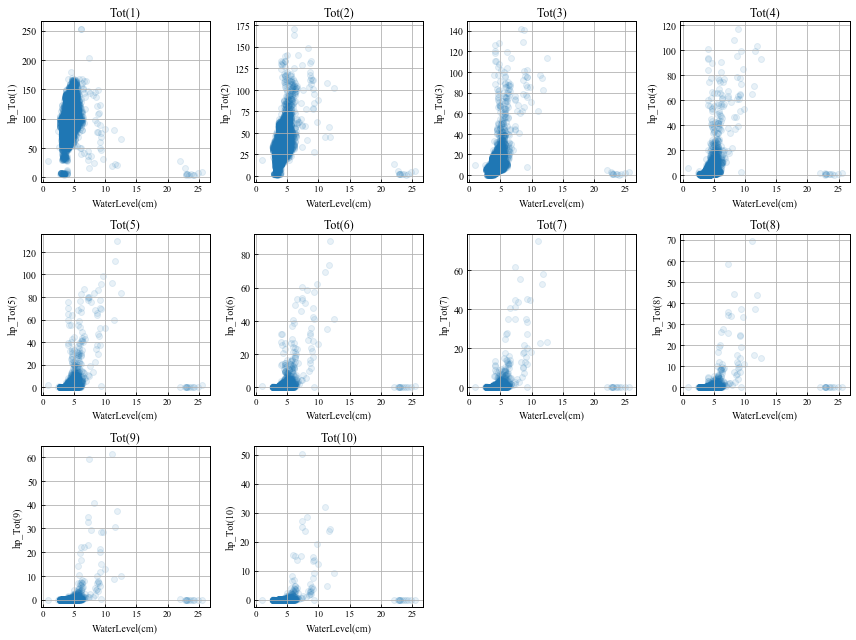

In [64]:
dispgraphs.scatter_graphs(df=df_2017_dia_mean_dropped, list_y_names=names_of_center, list_x_names=['WaterLevel(cm)']*10,
                                  figsize=(3*4, 3*3), alpha=0.1)

(0, 15)

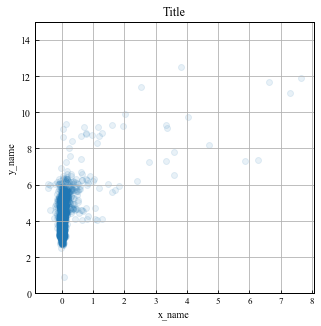

In [65]:
dispgraphs.scatter_graph(df=df_2017_dia_mean_dropped, y_name='WaterLevel(cm)', x_name= 'Load_Avg_difference',
                                  figsize=(5, 5), alpha=0.1)
plt.ylim(0,15)

## パルス数に1流砂の重量を掛けて流砂量にする

In [66]:
df_2017_dia_weigh =  df_2017_dia[names_of_center]*W_IDEAL
df_2018_dia_weigh =  df_2018_dia[names_of_center]*W_IDEAL


df_2017_dia_weigh_sum = df_2017_dia_weigh.sum(axis=1)
df_2018_dia_weigh_sum = df_2018_dia_weigh.sum(axis=1)


df_2017_dia_mean_dropped_weigh = df_2017_dia_mean_dropped[names_of_center]*W_IDEAL
df_2017_dia_mean_dropped_weigh_sum = df_2017_dia_mean_dropped_weigh.sum(axis=1)

df_2018_dia_mean_dropped_weigh = df_2018_dia_mean_dropped[names_of_center]*W_IDEAL
df_2018_dia_mean_dropped_weigh_sum = df_2018_dia_mean_dropped_weigh.sum(axis=1)

In [67]:
df_2017_dia_mean_dropped_weigh_sum.head(), df_2017_dia_weigh_sum.head()

(TIMESTAMP
 2016-06-25 02:00:00    0.370912
 2016-06-25 02:30:00    0.569499
 2016-06-25 03:00:00    0.599939
 2016-06-25 03:30:00    0.716935
 2016-06-25 04:00:00    2.283420
 dtype: float64, TIMESTAMP
 2016-06-03 00:01:00    0.02588
 2016-06-03 00:02:00    0.02518
 2016-06-03 00:03:00    0.02814
 2016-06-03 00:04:00    0.02480
 2016-06-03 00:05:00    0.02869
 dtype: float64)

## 流砂量calcとobsの相関

In [68]:
df_qcalc = pd.concat([df_2017_dia_mean_dropped_weigh_sum/0.5671*1.43, df_2017_dia_mean_dropped['Load_Avg_difference']], axis=1)
df_qcalc.columns = ['calc.', 'obs.']

-0.032260881809758266 1.2910904542503698 0.061448671307491


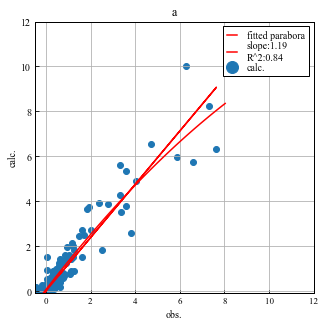

In [71]:
dispgraphs.scatter_graph(df_qcalc, y_name='calc.', x_name='obs.', figsize=(5,5), title='a',
                              ylabel='calc.', xlabel='obs.', least_squares=True, linear_regression=True)
dispgraphs.set_xy_lims_for_current_graph(xlim=(-0.5, 12), ylim=(-0.1, 12))

0.9905547855209929

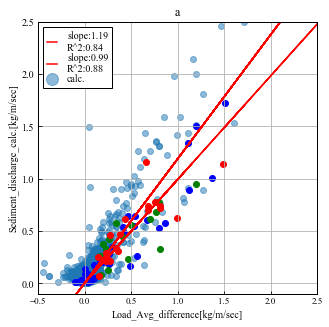

In [72]:
dispgraphs.scatter_graph(df_qcalc, 'calc.', 'obs.', figsize=(5,5), title='a', alpha=0.5,
                              ylabel='calc.', xlabel='obs.', least_squares=False, linear_regression=True)
dispgraphs.set_xy_lims_for_current_graph(xlim=(-0.5, 2.5), ylim=(-0.1, 2.5))

for i, qcalc in enumerate(qcalc_2018_events):
#     qobs = df_2018_dia_mean_events[i]['Load_Avg_difference'].values.reshape(len(df_2018_dia_mean_events[i]['Load_Avg_difference']),1)
    qobs = df_2018_dia_mean_events[i]['Load_Avg_difference']
    plt.scatter(qobs, qcalc, color=event_color_2018_dia_mean_events[i])
plt.xlabel('Load_Avg_difference[kg/m/sec]')
plt.ylabel('Sediment_discharge_calc.[kg/m/sec]')

linear_regression(qcalc_2018_events_concat, qobs_2018_events_concat)

## 流砂量（dia）と水深との関係（水深が深いときにサルテーションがとうなるか）

hp_Tot(1)とho_Tot(10)を比較すると、小さい粒径（Tot(1)）の流砂は比較的相関があるように見えるが、Tot(10)では水深によらないところがある。

(0, 15)

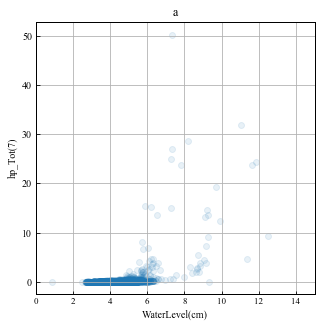

In [73]:
dispgraphs.scatter_graph(df_2017_dia_mean_dropped, y_name='hp_Tot(10)', x_name='WaterLevel(cm)', figsize=(5,5), title='a',
                              ylabel='hp_Tot(7)', xlabel='WaterLevel(cm)', 
                            least_squares=False, linear_regression=False, alpha=0.1)
plt.xlim(0,15)

(0, 15)

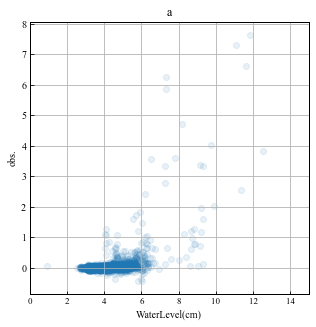

In [74]:
dispgraphs.scatter_graph(df_2017_dia_mean_dropped, y_name='Load_Avg_difference', x_name='WaterLevel(cm)', figsize=(5,5), title='a',
                              ylabel='obs.', xlabel='WaterLevel(cm)', least_squares=False, linear_regression=False, alpha=0.1)
plt.xlim(0,15)

この結果から、粒径分布は水深だけによらないことが分かる。→土砂供給量に変動があることが確認

In [75]:
df_2017_dia_mean_dropped.head()

,hp_Tot(1),hp_Tot(2),hp_Tot(3),hp_Tot(4),hp_Tot(5),hp_Tot(6),hp_Tot(7),hp_Tot(8),hp_Tot(9),hp_Tot(10),Load_Avg,Load_Avg_difference,WaterLevel(cm)
TIMESTAMP,,,,,,,,,,,,,
2016-06-25 02:00:00,117.133333,140.166667,113.500000,77.066667,42.866667,14.833333,4.700000,2.466667,2.333333,2.300000,205.4,0.600000,6.709033
2016-06-25 02:30:00,97.233333,147.966667,141.866667,108.666667,68.433333,28.333333,12.633333,7.233333,5.066667,3.000000,224.6,1.113333,8.312667
2016-06-25 03:00:00,93.333333,130.733333,129.100000,95.666667,66.233333,31.400000,17.400000,12.000000,7.133333,2.466667,260.3,1.196667,8.672667
2016-06-25 03:30:00,77.166667,133.866667,140.600000,117.333333,86.166667,35.966667,17.833333,11.066667,8.000000,3.866667,292.8,1.276667,8.842667
2016-06-25 04:00:00,22.900000,56.300000,93.933333,99.100000,112.133333,73.766667,52.866667,37.266667,30.466667,23.666667,335.0,6.613333,11.646667


## 時期指定して粒径分布可視化

In [76]:
df_2017_dia_mean_dropped_weigh.head()

,hp_Tot(1),hp_Tot(2),hp_Tot(3),hp_Tot(4),hp_Tot(5),hp_Tot(6),hp_Tot(7),hp_Tot(8),hp_Tot(9),hp_Tot(10)
TIMESTAMP,,,,,,,,,,
2016-06-25 02:00:00,0.017570,0.030837,0.032915,0.050093,0.039009,0.029073,0.014147,0.017045,0.025223,0.115000
2016-06-25 02:30:00,0.014585,0.032553,0.041141,0.070633,0.062274,0.055533,0.038026,0.049982,0.054771,0.150000
2016-06-25 03:00:00,0.014000,0.028761,0.037439,0.062183,0.060272,0.061544,0.052374,0.082920,0.077111,0.123333
2016-06-25 03:30:00,0.011575,0.029451,0.040774,0.076267,0.078412,0.070495,0.053678,0.076471,0.086480,0.193333
2016-06-25 04:00:00,0.003435,0.012386,0.027241,0.064415,0.102041,0.144583,0.159129,0.257513,0.329345,1.183333


In [77]:
def extract_term_and_sum(df, start, end):
    """
    df : df's index has to be datetime
    start, end : ideal shape would be like '2016-06-25 02:00:00'
    
    """
    df_sum = df[start: end].sum()
    return df_sum


print(extract_term_and_sum(df_2017_dia_weigh,
                     start='2016-06-25 02:00:00', end=df_2017_dia_mean_dropped_weigh.index[-1]))
    
print(extract_term_and_sum(df_2017_dia_weigh,
                     start='2017-09-21 00:00:00', end=df_2017_dia_mean_dropped_weigh.index[-1]))

print(df_2017_dia_mean_dropped_weigh.index[-1])

hp_Tot(1)      7965.91005
hp_Tot(2)      4744.08176
hp_Tot(3)      1909.31070
hp_Tot(4)      1537.36115
hp_Tot(5)      1417.93470
hp_Tot(6)      1528.76276
hp_Tot(7)      1626.43544
hp_Tot(8)      2938.40149
hp_Tot(9)      4665.81220
hp_Tot(10)    13163.45000
dtype: float64
hp_Tot(1)     150.04020
hp_Tot(2)      92.55334
hp_Tot(3)      45.96500
hp_Tot(4)      47.74510
hp_Tot(5)      37.67673
hp_Tot(6)      30.15852
hp_Tot(7)      16.50985
hp_Tot(8)      11.56734
hp_Tot(9)       5.13475
hp_Tot(10)      1.80000
dtype: float64
2017-09-27 21:30:00


In [78]:
print(extract_term_and_sum(df_2017_dia_mean_dropped_weigh*30,
                     start='2016-06-25 02:00:00', end=df_2017_dia_mean_dropped_weigh.index[-1]))

hp_Tot(1)     3304.02120
hp_Tot(2)     1871.68806
hp_Tot(3)      653.47991
hp_Tot(4)      418.37835
hp_Tot(5)      292.47036
hp_Tot(6)      282.55360
hp_Tot(7)      250.04973
hp_Tot(8)      354.64884
hp_Tot(9)      415.61207
hp_Tot(10)    1067.05000
dtype: float64


In [79]:
print(W_IDEAL, TARGET_TOT)

[0.00015 0.00022 0.00029 0.00065 0.00091 0.00196 0.00301 0.00691 0.01081
 0.05   ] ['-2mm', '3-5mm', '5-6mm', '6-7mm', '7-8.5mm', '8.5-10mm', '10-12.5mm', '12.5-15mm', '15-20mm', '25-30mm', '30mm-']


## 9/21(大粒径流砂が少ないイベント)に注目

In [80]:
start_921 = '2017-09-21 00:00:00'
# end_921 = df_2017_dia_mean_dropped_weigh.index[-1]
end_921 = '2017-09-23 00:00:00'
# end_921 = '2017-10-01 00:00:00'


df_2017_921_dia_weigh =  df_2017_dia_weigh[start_921: end_921]
df_2017_921_dia_weigh_sum = df_2017_dia_weigh_sum[start_921: end_921]

df_2017_921_dia_mean_dropped = df_2017_dia_mean_dropped[start_921: end_921]

df_2017_921_dia_mean_dropped_weigh = df_2017_dia_mean_dropped[start_921: end_921]
df_2017_921_dia_mean_dropped_weigh_sum = df_2017_dia_mean_dropped_weigh_sum[start_921: end_921]


Tot(8~10)の値が小さい→大粒径流砂が少ない

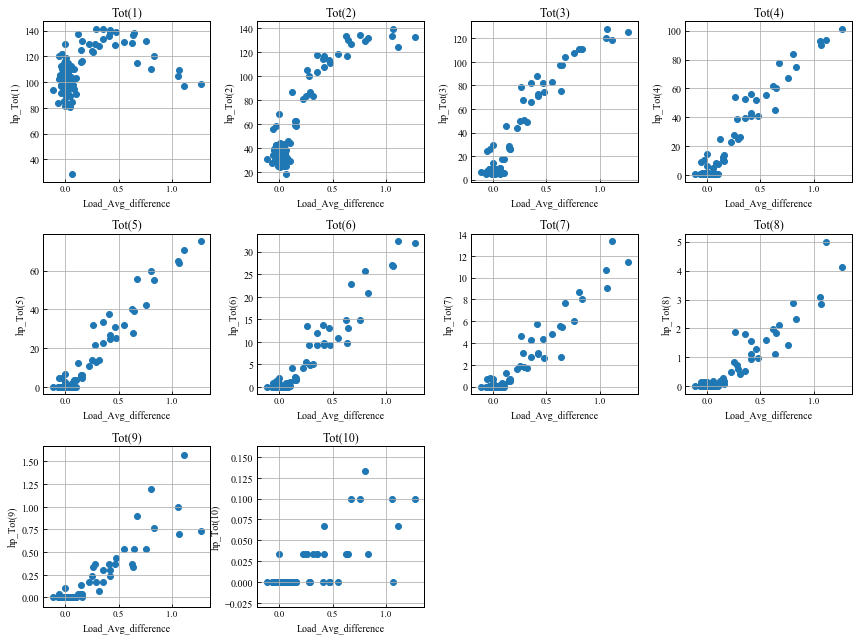

In [83]:
dispgraphs.scatter_graphs(df=df_2017_921_dia_mean_dropped, list_y_names=names_of_center, list_x_names=['Load_Avg_difference']*10
                             ,figsize=(3*4, 3*3), alpha=1)

In [84]:
df_qcalc_2017_921 = (df_2017_921_dia_weigh.sum())/0.56*1.43

for i in range(10):
    print(df_qcalc_2017_921.index[i], round(df_qcalc_2017_921[i], 1),'kg', round(W_IDEAL[i], 5), TARGET_TOT[i+1])

print('sum =', round(sum(df_qcalc_2017_921),1), 'kg')
print('obs =', round(df_2017['Load_Avg'][end_921] - df_2017['Load_Avg'][start_921]), 'kg')


hp_Tot(1) 118.8 kg 0.00015 3-5mm
hp_Tot(2) 93.3 kg 0.00022 5-6mm
hp_Tot(3) 63.0 kg 0.00029 6-7mm
hp_Tot(4) 79.5 kg 0.00065 7-8.5mm
hp_Tot(5) 69.5 kg 0.00091 8.5-10mm
hp_Tot(6) 58.3 kg 0.00196 10-12.5mm
hp_Tot(7) 32.5 kg 0.00301 12.5-15mm
hp_Tot(8) 24.1 kg 0.00691 15-20mm
hp_Tot(9) 10.7 kg 0.01081 25-30mm
hp_Tot(10) 4.1 kg 0.05 30mm-
sum = 553.9 kg
obs = 484.0 kg


In [85]:
df_qcalc_2017_921_30min = pd.concat([df_2017_921_dia_mean_dropped_weigh_sum/0.5671*1.43, df_2017_dia_mean_dropped['Load_Avg_difference'][start_921:end_921]], axis=1)
df_qcalc_2017_921_30min.columns = ['calc.', 'obs.']

-0.09248886750223312 0.805034339742408 0.06962160273095394


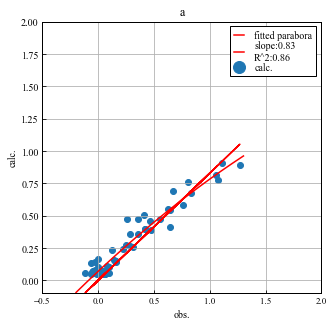

In [88]:
dispgraphs.scatter_graph(df_qcalc_2017_921_30min.dropna(), y_name='calc.', x_name='obs.', figsize=(5,5), title='a',
                              ylabel='calc.', xlabel='obs.', least_squares=True, linear_regression=True)
dispgraphs.set_xy_lims_for_current_graph(xlim=(-0.5, 2), ylim=(-0.1, 2))

In [89]:
print("3-5mm", round(df_qcalc_2017_921[0]))
print("5-7mm", round(df_qcalc_2017_921[1] + df_qcalc_2017_921[2]))
print("7-10mm", round(df_qcalc_2017_921[3] + df_qcalc_2017_921[4]))
print("10-20mm", round(df_qcalc_2017_921[5] + df_qcalc_2017_921[6] + df_qcalc_2017_921[7]))
print("20-30mm", round(df_qcalc_2017_921[8]))
print("30-mm", round(df_qcalc_2017_921[9]))

3-5mm 119.0
5-7mm 156.0
7-10mm 149.0
10-20mm 115.0
20-30mm 11.0
30-mm 4.0


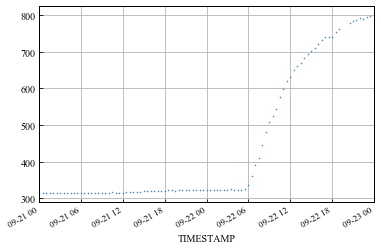

In [93]:
dispgraphs.time_series_graph(df_2017_dia_mean_dropped[start_921:end_921], col_name='Load_Avg')

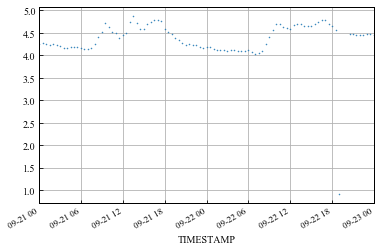

In [94]:
dispgraphs.time_series_graph(df_2017_dia_mean_dropped[start_921:end_921], col_name='WaterLevel(cm)')

[47.947728098685715, 8.112970539038912, 33.30959028115462, 231.05324898190722, 102.61354050628148]
[52.490255016044976, 14.847496619433779, 43.66686691531083, 187.87406397162763, 101.9482502296203]
[38.24773584061444, 19.896519400052433, 45.02817687249126, 122.6732961215094, 77.37065607898121]
[43.65580344793155, 36.765847380106145, 71.0564192603274, 157.1043513139446, 104.79842065911153]
[33.92481841386189, 36.28226611805269, 68.65079895416687, 147.79741257582427, 106.0405571727082]
[36.006565711448694, 46.44516002520381, 94.54327055362431, 222.61938337696137, 165.45915688977712]
[22.64241896165691, 36.3864941114052, 93.36697768763482, 239.95809379823183, 202.83452641454417]
[20.45950185001329, 37.21613901609908, 132.94041802201485, 427.7200200373829, 435.45290844063226]
[13.488409400619878, 33.2237824128069, 149.10677819698427, 495.4838612466209, 484.6610878290627]
[21.550578516231425, 106.21247180615785, 350.6126307500017, 205.20364701699387, 425.1561338995758]



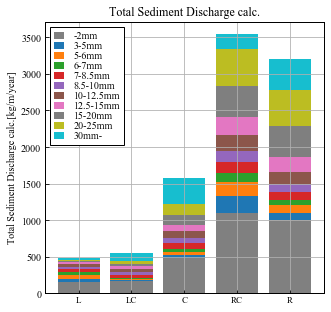

In [95]:
def python_list_add(in1, in2):
    wrk = np.array(in1) + np.array(in2)
    return wrk.tolist()

def display_stacked_barplot(list_of_arraies):
    num_of_tots = len(list_of_arraies)    
    %matplotlib inline
    fig = plt.figure(figsize=(5, 5))
    
    # Names of group and bar width
    names = ['L','LC','C','RC','R']
    legend = ['-2mm', '3-5mm', '5-6mm', '6-7mm', '7-8.5mm', '8.5-10mm', '10-12.5mm', '12.5-15mm', '15-20mm', '20-25mm', '30mm-']
    barWidth = 1

    # The position of the bars on the x-axis
    pre_ylist = []
    ax = plt.subplot(1, 1, 1)
    for i, y_list in enumerate(list_of_arraies):
        if i == 0:
            ax.bar(names, qfine_2018_cumulated, color='gray', label=legend[0])
            ax.bar(names, y_list, bottom=qfine_2018_cumulated, label=legend[1])
            print(y_list)
            pre_ylist = python_list_add(y_list, qfine_2018_cumulated)
        else:
            ax.bar(names, y_list, bottom=pre_ylist, label=legend[i+1])
            print(y_list)
            pre_ylist = python_list_add(pre_ylist, y_list)

    ax.set_title('Total Sediment Discharge calc.')
    ax.set_ylabel('Total Sediment Discharge calc.[kg/m/year]')
    ax.legend()
    
    print()
    


display_stacked_barplot(list_of_Tots)

[24.85743184941847, 12.212971829953414, 63.34438777488739, 151.74729977058428, 232.41797516399959]
[19.767471235957906, 9.712168610846103, 50.37360137944997, 120.67458945560709, 184.82664124779336]
[28.56342392207001, 10.778669593892724, 59.25256222680729, 179.3517034983003, 213.24858053374734]


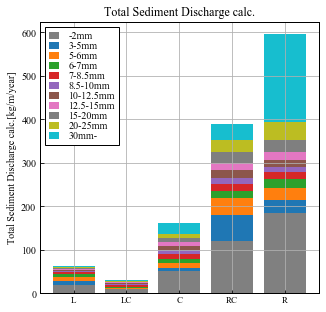

In [96]:
list_of_qbedload_2018_each_Spring = []
cut_list_of_dfs('2018-01-01 00:00', '2018-05-01 00:00', list_of_qbedload_2018_each, list_of_qbedload_2018_each_Spring)

#粒径別の堆積流砂量の分布をみる
list_of_qbedload_2018_Spring = []
list_of_dfs_sumall_col(list_of_qbedload_2018_each_Spring, list_of_qbedload_2018_Spring)

#粒径別の堆積流砂量の分布をみる
#sediment discharge
list_of_qbedload_2018_cumulated_Spring = []
list_of_dfs_sumall_row(list_of_qbedload_2018_each_Spring, list_of_qbedload_2018_cumulated_Spring)

#list番号[0,1,2,3,,,,9] = [Tot(1), Tot(2), Tot(3),....Tot(10)]
#空のリスト作成
list_of_Tots_Spring = [[] for i in range(10)]
for tot_num in range(10):
    for sd in list_of_qbedload_2018_cumulated_Spring:
        corrected_sd = list(map(lambda x: x * Correction_factor*(1+ Correction_factor_fine), sd))
        list_of_Tots_Spring[tot_num].append(corrected_sd[tot_num])
    
qbedload_2018_cumulated_Spring = []
for qbedload_all_Tot in list_of_qbedload_2018_cumulated_Spring:
    qbedload_2018_cumulated_Spring.append(Correction_factor* qbedload_all_Tot.sum())
    

qfine_2018_cumulated_Spring = list(map(lambda x: x * Correction_factor_fine*Correction_factor, qbedload_2018_cumulated_Spring))

print(qbedload_2018_cumulated_Spring)
print(qfine_2018_cumulated_Spring)

def display_stacked_barplot_Spring(list_of_arraies):
    num_of_tots = len(list_of_arraies)    
    %matplotlib inline
    fig = plt.figure(figsize=(5, 5))
    
    # Names of group and bar width
    names = ['L','LC','C','RC','R']
    legend = ['-2mm', '3-5mm', '5-6mm', '6-7mm', '7-8.5mm', '8.5-10mm', '10-12.5mm', '12.5-15mm', '15-20mm', '20-25mm', '30mm-']
    barWidth = 1

    # The position of the bars on the x-axis
    pre_ylist = []
    ax = plt.subplot(1, 1, 1)
    for i, y_list in enumerate(list_of_arraies):
        if i == 0:
            ax.bar(names, qfine_2018_cumulated_Spring, color='gray', label=legend[0])
            ax.bar(names, y_list, bottom=qfine_2018_cumulated_Spring, label=legend[1])
            pre_ylist = python_list_add(y_list, qfine_2018_cumulated_Spring)
            print(pre_ylist)
        else:
            ax.bar(names, y_list, bottom=pre_ylist, label=legend[i+1])
            pre_ylist = python_list_add(pre_ylist, y_list)

    ax.set_title('Total Sediment Discharge calc.')
    ax.set_ylabel('Total Sediment Discharge calc.[kg/m/year]')
    ax.legend()
    
display_stacked_barplot_Spring(list_of_Tots_Spring)

## 2018年4月(大粒径流砂が多いイベント)に注目

In [97]:
start_415 = '2018-04-15 0:00'
# start_415 = df_2017_dia_mean_dropped_weigh.index[1]

# end_921 = df_2017_dia_mean_dropped_weigh.index[-1]
end_415 = '2018-04-28 0:00'
# end_415 = '2018-04-28 0:00'


df_2018_415_dia_weigh =  df_2018_dia_weigh[start_415: end_415]
df_2018_415_dia_weigh_sum = df_2018_dia_weigh_sum[start_415: end_415]

df_2018_415_dia_mean_dropped = df_2018_dia_mean_dropped[start_415: end_415]

df_2018_415_dia_mean_dropped_weigh = df_2018_dia_mean_dropped[start_415: end_415]
df_2018_415_dia_mean_dropped_weigh_sum = df_2018_dia_mean_dropped_weigh_sum[start_415: end_415]


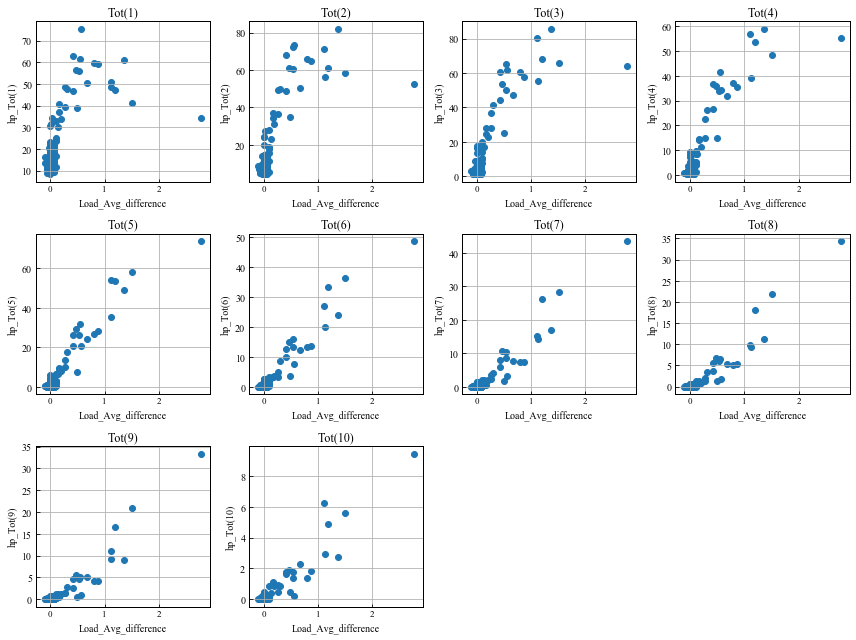

In [100]:
dispgraphs.scatter_graphs(df=df_2018_415_dia_mean_dropped, list_y_names=names_of_center, list_x_names=['Load_Avg_difference']*10
                             ,figsize=(3*4, 3*3), alpha=1)

In [101]:
df_qcalc_2018_415 = (df_2018_415_dia_weigh.sum()) *1.43

for i in range(10):
    print(df_qcalc_2018_415.index[i], round(df_qcalc_2018_415[i], 1),'kg', round(W_IDEAL[i], 5), TARGET_TOT[i+1])

print('sum =', round(sum(df_qcalc_2018_415),1), 'kg')
# print('obs =', round(df_2018['Load_Avg'][end_415] - df_2018['Load_Avg'][start_415]), 'kg')
# print('obs*0.567 =', round((df_2018['Load_Avg'][end_415] - df_2018['Load_Avg'][start_415])*0.567), 'kg')



hp_Tot(1) 63.1 kg 0.00015 3-5mm
hp_Tot(2) 67.4 kg 0.00022 5-6mm
hp_Tot(3) 58.6 kg 0.00029 6-7mm
hp_Tot(4) 76.1 kg 0.00065 7-8.5mm
hp_Tot(5) 80.6 kg 0.00091 8.5-10mm
hp_Tot(6) 79.8 kg 0.00196 10-12.5mm
hp_Tot(7) 69.3 kg 0.00301 12.5-15mm
hp_Tot(8) 100.7 kg 0.00691 15-20mm
hp_Tot(9) 137.4 kg 0.01081 25-30mm
hp_Tot(10) 261.8 kg 0.05 30mm-
sum = 994.7 kg


In [102]:
df_qcalc_2018_415_30min = pd.concat([df_2018_415_dia_mean_dropped_weigh_sum/0.5671*1.43, df_2018_dia_mean_dropped['Load_Avg_difference'][start_415:end_415]], axis=1)
df_qcalc_2018_415_30min.columns = ['calc.', 'obs.']

0.057461369269951636 1.1846038885326275 0.019231267756973276


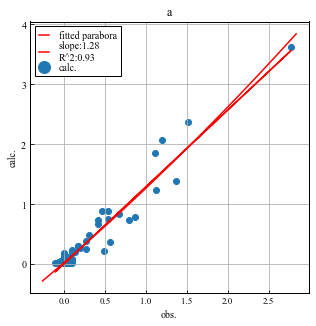

In [105]:
dispgraphs.scatter_graph(df_qcalc_2018_415_30min.dropna(), y_name='calc.', x_name='obs.', figsize=(5,5), title='a',
                              ylabel='calc.', xlabel='obs.', least_squares=True, linear_regression=True)
# graphs_object.set_xy_lims_for_current_graph(xlim=(-0.5, 2), ylim=(-0.1, 2))

In [106]:
print("3-5mm", round(df_qcalc_2018_415[0]))
print("5-7mm", round(df_qcalc_2018_415[1] + df_qcalc_2018_415[2]))
print("7-10mm", round(df_qcalc_2018_415[3] + df_qcalc_2018_415[4]))
print("10-20mm", round(df_qcalc_2018_415[5] + df_qcalc_2018_415[6] + df_qcalc_2018_415[7]))
print("20-30mm", round(df_qcalc_2018_415[8]))
print("30-mm", round(df_qcalc_2018_415[9]))

3-5mm 63.0
5-7mm 126.0
7-10mm 157.0
10-20mm 250.0
20-30mm 137.0
30-mm 262.0


## 7月16日（ふるい日）

In [107]:
start_716 = '2018-05-01 0:00'
# start_415 = df_2017_dia_mean_dropped_weigh.index[1]

# end_921 = df_2017_dia_mean_dropped_weigh.index[-1]
# end_716 = '2018-07-16 0:00'
end_716 = '2018-05-20 0:00'

# end_415 = '2018-04-28 0:00'


df_2018_716_dia_weigh =  df_2018_dia_weigh[start_716: end_716]
df_2018_716_dia_weigh_sum = df_2018_dia_weigh_sum[start_716: end_716]

df_2018_716_dia_mean_dropped = df_2018_dia_mean_dropped[start_716: end_716]

df_2018_716_dia_mean_dropped_weigh = df_2018_dia_mean_dropped[start_716: end_716]
df_2018_716_dia_mean_dropped_weigh_sum = df_2018_dia_mean_dropped_weigh_sum[start_716: end_716]

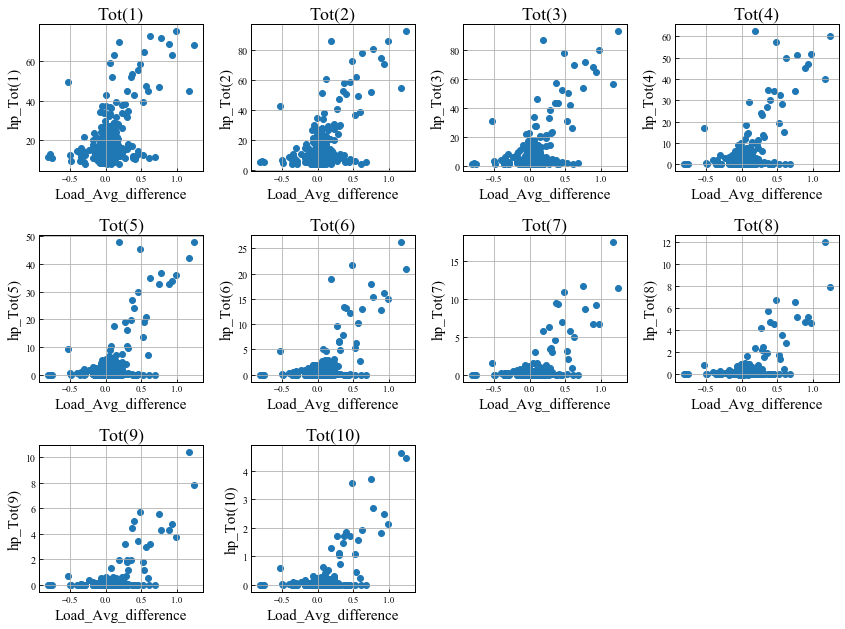

In [123]:
dispgraphs.scatter_graphs(df=df_2018_716_dia_mean_dropped, list_y_names=names_of_center, list_x_names=['Load_Avg_difference']*10
                             ,figsize=(3*4, 3*3), alpha=1)

In [124]:
df_qcalc_2018_716 = (df_2018_716_dia_weigh.sum()) *1.43

for i in range(10):
    print(df_qcalc_2018_716.index[i], round(df_qcalc_2018_716[i], 1),'kg', round(W_IDEAL[i], 5), TARGET_TOT[i+1])

print('sum =', round(sum(df_qcalc_2018_716),1), 'kg')
# print('obs =', round(df_2018['Load_Avg'][end_415] - df_2018['Load_Avg'][start_415]), 'kg')
# print('obs*0.567 =', round((df_2018['Load_Avg'][end_415] - df_2018['Load_Avg'][start_415])*0.567), 'kg')



hp_Tot(1) 94.7 kg 0.00015 3-5mm
hp_Tot(2) 85.5 kg 0.00022 5-6mm
hp_Tot(3) 55.1 kg 0.00029 6-7mm
hp_Tot(4) 53.2 kg 0.00065 7-8.5mm
hp_Tot(5) 43.9 kg 0.00091 8.5-10mm
hp_Tot(6) 38.7 kg 0.00196 10-12.5mm
hp_Tot(7) 29.3 kg 0.00301 12.5-15mm
hp_Tot(8) 39.9 kg 0.00691 15-20mm
hp_Tot(9) 52.6 kg 0.01081 25-30mm
hp_Tot(10) 127.1 kg 0.05 30mm-
sum = 620.1 kg


In [125]:
df_qcalc_2018_716_30min = pd.concat([df_2018_716_dia_mean_dropped_weigh_sum/0.5671*1.43, df_2018_dia_mean_dropped['Load_Avg_difference'][start_716:end_716]], axis=1)
df_qcalc_2018_716_30min.columns = ['calc.', 'obs.']

In [126]:
print("3-5mm", round(df_qcalc_2018_716[0]))
print("5-7mm", round(df_qcalc_2018_716[1] + df_qcalc_2018_716[2]))
print("7-10mm", round(df_qcalc_2018_716[3] + df_qcalc_2018_716[4]))
print("10-20mm", round(df_qcalc_2018_716[5] + df_qcalc_2018_716[6] + df_qcalc_2018_716[7]))
print("20-30mm", round(df_qcalc_2018_716[8]))
print("30-mm", round(df_qcalc_2018_716[9]))

3-5mm 95.0
5-7mm 141.0
7-10mm 97.0
10-20mm 108.0
20-30mm 53.0
30-mm 127.0


## 粒度分布

In [127]:








}print(TARGET_TOT)

['-2mm', '3-5mm', '5-6mm', '6-7mm', '7-8.5mm', '8.5-10mm', '10-12.5mm', '12.5-15mm', '15-20mm', '25-30mm', '30mm-']


下のデータフレームは、ピット内のふるい結果である。上から、表面から-30cm、-45cm、-60cmの位置の土砂である。

In [128]:
x_furui = [1, 2, 5, 7, 9, 15, 31.5, 50] #furui粒径界の上限
x_tot = [2, 5, 6, 7, 8.5, 10, 12.5, 15, 20, 30, 50] #Tot粒径界の上限
g_furui = ['-1mm(g)', '1-2mm(g)', '2-5mm(g)', '5-7mm(g)', '7-9mm(g)', '9-15mm(g)', '19-31.5mm(g)', '31.5mm-(g)']
percent_furui = ['-1mm(%)', '1-2mm(%)', '2-5mm(%)', '5-7mm(%)', '7-9mm(%)', '9-15mm(%)', '19-31.5mm(%)', '31.5mm-(%)']
df_furui

,31.5mm-(g),19-31.5mm(g),9-15mm(g),7-9mm(g),5-7mm(g),2-5mm(g),1-2mm(g),-1mm(g),31.5mm-(%),19-31.5mm(%),9-15mm(%),7-9mm(%),5-7mm(%),2-5mm(%),1-2mm(%),-1mm(%)
TIMESTAMP,,,,,,,,,,,,,,,,
2017-11-23,134,507,1120,804,1557,2718,2163,3079,1.109088,4.196325,9.269988,6.654527,12.886939,22.496275,17.902665,25.484191
2017-11-23,0,61,423,439,1671,4498,3408,2147,0.000000,0.482328,3.344667,3.471179,13.212620,35.565747,26.947102,16.976358
2017-11-23,0,81,697,1091,2481,4775,2073,1296,0.000000,0.648311,5.578678,8.732191,19.857532,38.218345,16.591964,10.372979
2018-04-28,1172,1713,1690,787,1046,2125,2447,3634,8.019707,11.721637,11.564253,5.385247,7.157520,14.540851,16.744218,24.866566
2018-04-28,901,1223,1678,747,1226,2395,2619,3697,6.219798,8.442634,11.583598,5.156703,8.463344,16.533204,18.079525,25.521193
2018-04-28,1267,1086,1981,823,1174,2340,2386,3213,8.878767,7.610371,13.882270,5.767344,8.227050,16.398038,16.720392,22.515767
2018-07-16,387,551,975,372,530,1269,2048,3800,3.896496,5.547725,9.816754,3.745469,5.336287,12.776883,20.620217,38.260169
2018-07-16,458,678,1240,417,560,974,1211,2502,5.696517,8.432836,15.422886,5.186567,6.965174,12.114428,15.062189,31.119403
2018-07-16,866,854,814,409,591,1249,1491,2556,9.807475,9.671574,9.218573,4.631937,6.693092,14.144960,16.885617,28.946772


(0.1, 100)

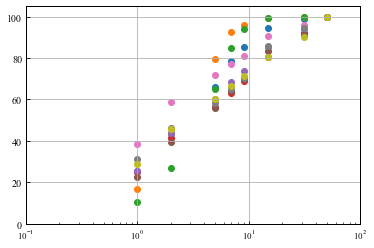

In [129]:
for i in range(9):
    furui_percent_cumsum = np.cumsum(df_furui[i:i+1][percent_furui], axis=1)
    plt.scatter(x_furui, furui_percent_cumsum)
plt.xscale('log')
plt.ylim(0,105)
plt.xlim((0.1), 100)

In [130]:
PERCENT_UNDER_2mm = 43
percent_qcalc_2017_921 = (100-PERCENT_UNDER_2mm)*df_qcalc_2017_921/sum(df_qcalc_2017_921)

9/21日のデータとふるい結果比較  
df_furuiの番号を変えていくとピットの深さごとの粒度分布が見れる

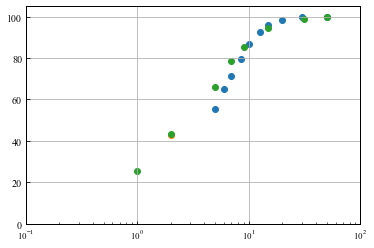

In [131]:
plt.scatter(x_tot[1:], np.cumsum(percent_qcalc_2017_921) + PERCENT_UNDER_2mm)
plt.scatter(x_tot[0], PERCENT_UNDER_2mm)
plt.xscale('log')
plt.ylim(0,105)
plt.xlim((0.1), 100)

furui_percent_cumsum = np.cumsum(df_furui[0:1][percent_furui], axis=1)
plt.scatter(x_furui, furui_percent_cumsum)

4/28日のデータとふるい結果比較

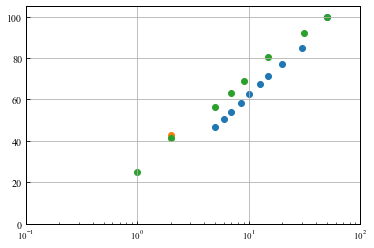

In [132]:
percent_qcalc_2018_415 = (100-PERCENT_UNDER_2mm)*df_qcalc_2018_415/sum(df_qcalc_2018_415)

plt.scatter(x_tot[1:], np.cumsum(percent_qcalc_2018_415) + PERCENT_UNDER_2mm)
plt.scatter(x_tot[0], PERCENT_UNDER_2mm)
plt.xscale('log')
plt.ylim(0,105)
plt.xlim((0.1), 100)

furui_percent_cumsum = np.cumsum(df_furui[3:4][percent_furui], axis=1)
plt.scatter(x_furui, furui_percent_cumsum)

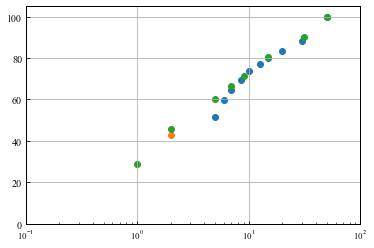

In [133]:
percent_qcalc_2018_716 = (100-PERCENT_UNDER_2mm)*df_qcalc_2018_716/sum(df_qcalc_2018_716)

plt.scatter(x_tot[1:], np.cumsum(percent_qcalc_2018_716) + PERCENT_UNDER_2mm)
plt.scatter(x_tot[0], PERCENT_UNDER_2mm)
plt.xscale('log')
plt.ylim(0,105)
plt.xlim((0.1), 100)

furui_percent_cumsum = np.cumsum(df_furui[8:9][percent_furui], axis=1)
plt.scatter(x_furui, furui_percent_cumsum)

In [134]:
df_2017_921_dia_mean_dropped

,hp_Tot(1),hp_Tot(2),hp_Tot(3),hp_Tot(4),hp_Tot(5),hp_Tot(6),hp_Tot(7),hp_Tot(8),hp_Tot(9),hp_Tot(10),Load_Avg,Load_Avg_difference,WaterLevel(cm)
TIMESTAMP,,,,,,,,,,,,,
2017-09-21 00:00:00,114.933333,39.633333,8.633333,0.900000,0.200000,0.000000,0.033333,0.000000,0.000000,0.000000,315.0,-0.016667,4.255400
2017-09-21 00:30:00,112.133333,43.300000,7.833333,0.900000,0.000000,0.033333,0.033333,0.000000,0.000000,0.000000,314.3,0.050000,4.267500
2017-09-21 01:00:00,112.766667,39.900000,8.566667,1.133333,0.133333,0.066667,0.066667,0.000000,0.000000,0.000000,314.8,-0.043333,4.240600
2017-09-21 01:30:00,103.933333,34.766667,7.033333,1.033333,0.166667,0.033333,0.000000,0.000000,0.000000,0.000000,314.0,0.056667,4.218267
2017-09-21 02:00:00,104.900000,39.400000,7.666667,0.833333,0.100000,0.033333,0.000000,0.000000,0.000000,0.000000,314.2,-0.050000,4.238333
2017-09-21 02:30:00,113.866667,40.966667,8.500000,1.233333,0.133333,0.066667,0.000000,0.000000,0.000000,0.000000,314.5,0.010000,4.233500
2017-09-21 03:00:00,110.100000,41.500000,8.833333,0.866667,0.066667,0.033333,0.000000,0.000000,0.000000,0.000000,314.8,-0.026667,4.200433
2017-09-21 03:30:00,110.966667,40.033333,7.266667,0.900000,0.233333,0.033333,0.000000,0.000000,0.000000,0.000000,314.0,0.033333,4.166233
2017-09-21 04:00:00,110.566667,42.333333,8.400000,1.133333,0.166667,0.000000,0.033333,0.000000,0.000000,0.000000,314.5,-0.030000,4.165333


イベント内で見る

In [135]:
df_2017_921_dia_mean_dropped

count = 0
def count_restart():
    count = 0

if (df_2017_921_dia_mean_dropped[count:count+1]['hp_Tot(6)'] == 0).bool():
    tot = []
    for i in range(10):
        tot.append(df_2017_921_dia_mean_dropped[count:count+1]['hp_Tot({})'.format(i+1)])
    print(tot)


[TIMESTAMP
2017-09-21    114.933333
Name: hp_Tot(1), dtype: float64, TIMESTAMP
2017-09-21    39.633333
Name: hp_Tot(2), dtype: float64, TIMESTAMP
2017-09-21    8.633333
Name: hp_Tot(3), dtype: float64, TIMESTAMP
2017-09-21    0.9
Name: hp_Tot(4), dtype: float64, TIMESTAMP
2017-09-21    0.2
Name: hp_Tot(5), dtype: float64, TIMESTAMP
2017-09-21    0.0
Name: hp_Tot(6), dtype: float64, TIMESTAMP
2017-09-21    0.033333
Name: hp_Tot(7), dtype: float64, TIMESTAMP
2017-09-21    0.0
Name: hp_Tot(8), dtype: float64, TIMESTAMP
2017-09-21    0.0
Name: hp_Tot(9), dtype: float64, TIMESTAMP
2017-09-21    0.0
Name: hp_Tot(10), dtype: float64]


In [136]:
count_restart
print(count)

0


In [137]:
df_2017_921_dia_mean_dropped[count:count+1]['hp_Tot(6)'] == 0

TIMESTAMP
2017-09-21    True
Name: hp_Tot(6), dtype: bool

# より大胆にdiaを設定

<img src=images_path + "ranges_of_diameter_each_channel_detect.PNG">

In [138]:
print(amplification_factor)

{'Tot(1)': '1024', 'Tot(2)': '512', 'Tot(3)': '256', 'Tot(4)': '128', 'Tot(5)': '64', 'Tot(6)': '32', 'Tot(7)': '16', 'Tot(8)': '8', 'Tot(9)': '4', 'Tot(10)': '2'}


## 数スロットごとに差分を引いていく（Method2に変換）

In [139]:
df_2017_dia2 = pd.DataFrame()
#because the detection rate is 0.2-0.466
# df_2017_dia2['over30mm'] =  df_2017['hp_Tot(10)'] * 3
df_2017_dia2['over30mm'] = df_2017['hp_Tot(10)']

# df_2017_dia2['25-30mm'] = (df_2017['hp_Tot(9)'] - df_2017_dia2['over30mm']) * 3
df_2017_dia2['25-30mm'] = df_2017['hp_Tot(9)'] - df_2017['hp_Tot(10)']

# df_2017_dia2['10-15mm'] = (df_2017['hp_Tot(7)'] - df_2017['hp_Tot(9)'] - df_2017_dia2['25-30mm']*(2/3)) * 3
df_2017_dia2['10-15mm'] = df_2017['hp_Tot(7)'] - df_2017['hp_Tot(9)']


# df_2017_dia2['7-10mm'] = (df_2017['hp_Tot(5)'] - df_2017['hp_Tot(7)'] - df_2017_dia2['10-15mm']*(2/3)) * 3
df_2017_dia2['7-10mm'] = df_2017['hp_Tot(5)'] - df_2017['hp_Tot(7)']


df_2017_dia2['Load_Avg'] = df_2017['Load_Avg']
df_2017_dia2['Load_Avg_difference'] = df_2017['Load_Avg_difference']
df_2017_dia2['WaterLevel(cm)'] = df_2017['WL_FMR_Avg']

In [140]:
df_2017_dia2.head()

,over30mm,25-30mm,10-15mm,7-10mm,Load_Avg,Load_Avg_difference,WaterLevel(cm)
TIMESTAMP,,,,,,,
2016-06-03 00:01:00,0.0,0.0,0.0,0.0,158.0,0.0,3.336
2016-06-03 00:02:00,0.0,0.0,0.0,0.0,158.0,0.0,3.375
2016-06-03 00:03:00,0.0,0.0,0.0,0.0,157.9,-0.1,3.411
2016-06-03 00:04:00,0.0,0.0,0.0,0.0,157.9,0.0,3.406
2016-06-03 00:05:00,0.0,0.0,0.0,0.0,158.0,0.1,3.427


In [141]:
df_2017_dia2_mean = mean_of_df(df_2017_dia2)

-12.466666666666667


In [142]:
#今はmeanだけ使うからメモリが大きい元データを削除(あとでまたインポートする)
del df_2017_dia2

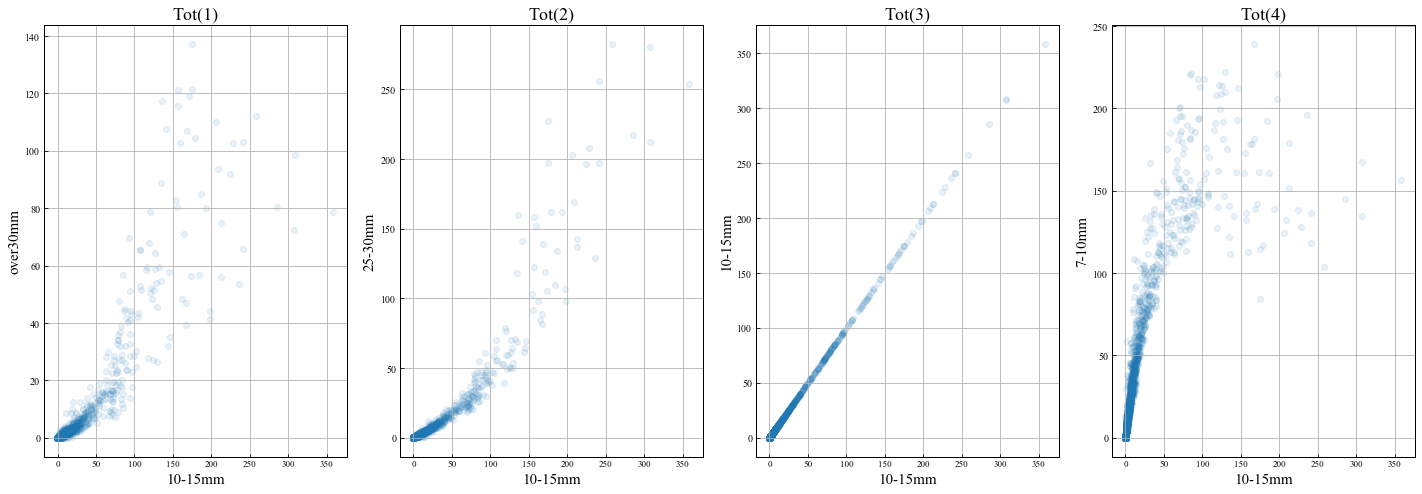

In [144]:
dispgraphs.scatter_graphs(df_2017_dia2_mean, ["over30mm","25-30mm","10-15mm","7-10mm"], ["10-15mm"]*4, figsize=(5*4,5*4), title='Title', 
                           ylabel='y_name', xlabel='x_name', least_squares=False, alpha=0.1)

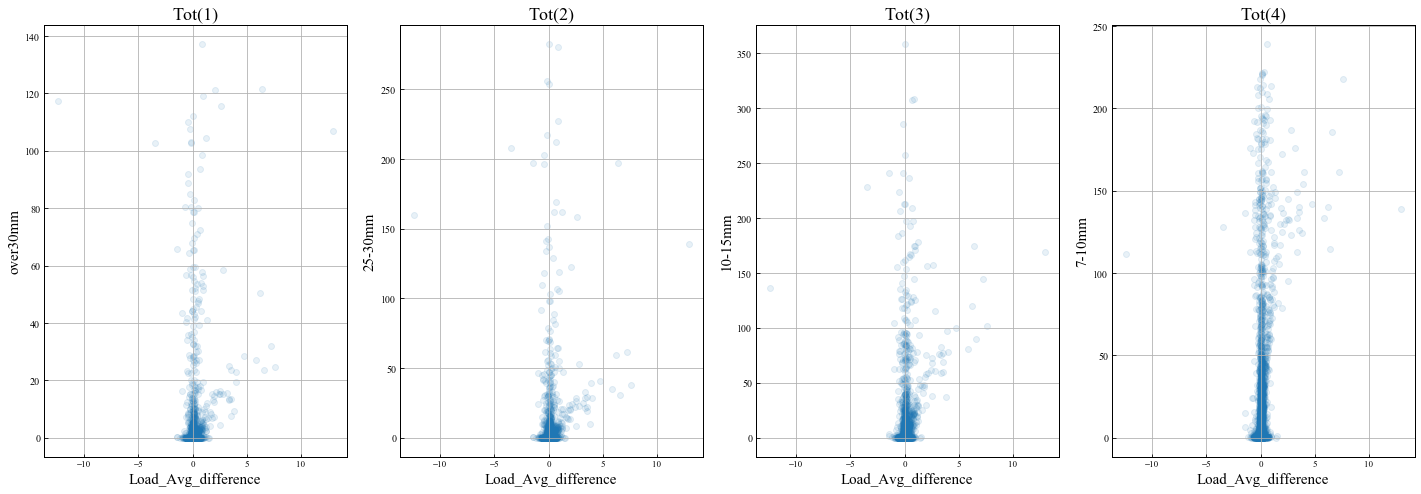

In [146]:
dispgraphs.scatter_graphs(df_2017_dia2_mean, ["over30mm","25-30mm","10-15mm","7-10mm"], ["Load_Avg_difference"]*4, figsize=(5*4,5*4), title='Title', 
                           ylabel='y_name', xlabel='x_name', least_squares=False, alpha=0.1)

# 季節ごとの変動

NameError: name 'df_2018' is not defined

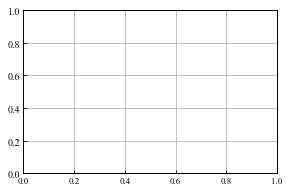

In [147]:
graph_pit_time_series_2017_2018()

In [148]:
print(amplification_factor)
for i in range(10):
    print(TARGET_TOT[i], W_IDEAL[i].round(6))

{'Tot(1)': '1024', 'Tot(2)': '512', 'Tot(3)': '256', 'Tot(4)': '128', 'Tot(5)': '64', 'Tot(6)': '32', 'Tot(7)': '16', 'Tot(8)': '8', 'Tot(9)': '4', 'Tot(10)': '2'}
-2mm 0.00015
3-5mm 0.00022
5-6mm 0.00029
6-7mm 0.00065
7-8.5mm 0.00091
8.5-10mm 0.00196
10-12.5mm 0.00301
12.5-15mm 0.00691
15-20mm 0.01081
25-30mm 0.05


## 粒径別流砂量

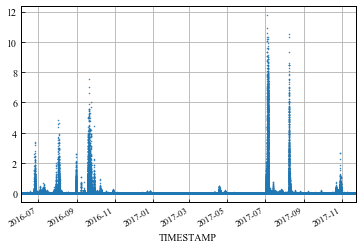

In [160]:
dispgraphs.time_series_graph(df_2017_dia_weigh, col_name='hp_Tot(10)')

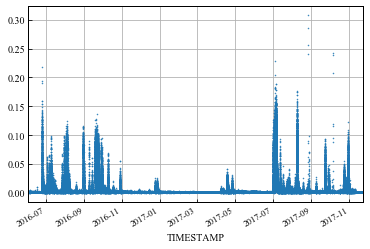

In [161]:
dispgraphs.time_series_graph(df_2017_dia_weigh, col_name='hp_Tot(5)')

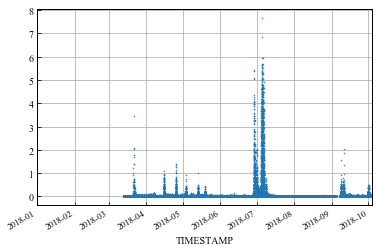

In [162]:
dispgraphs.time_series_graph(df_2018_dia_weigh, col_name='hp_Tot(10)')

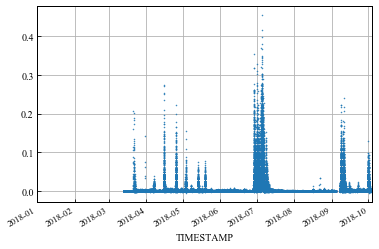

In [163]:
dispgraphs.time_series_graph(df_2018_dia_weigh, col_name='hp_Tot(7)')

## 粒径別流砂量の割合

## 水深に対する粒径別流砂量

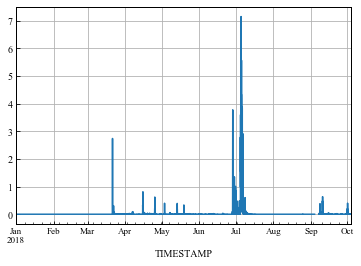

In [164]:
df_2018_mean['hp_Tot(10)'].div(np.array(df_2018_mean['WaterLevel(cm)']), fill_value=0).plot()

(-1, 100)

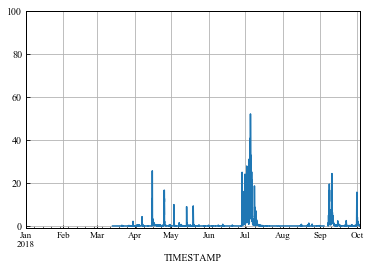

In [165]:
df_2018_mean['hp_Tot(5)'].div(np.array(df_2018_mean['WL_FMR_Avg']), fill_value=0).plot()
plt.ylim(-1, 100)

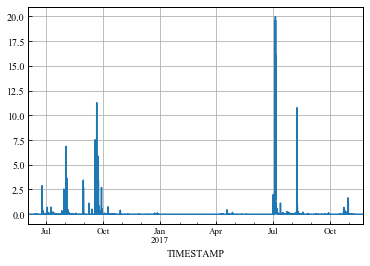

In [166]:
df_2017_mean['hp_Tot(10)'].div(np.array(df_2017_mean['WL_FMR_Avg']), fill_value=0).plot()

(-1, 250)

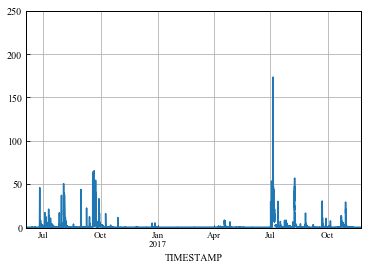

In [167]:
df_2017_mean['hp_Tot(5)'].div(np.array(df_2017_mean['WL_FMR_Avg']), fill_value=0).plot()
plt.ylim(-1, 250)

# 運動量で考える

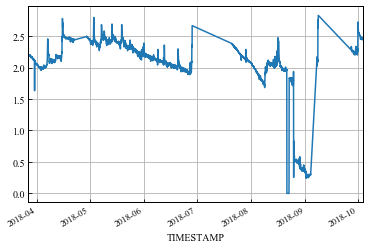

In [168]:
df_2018_mean_dropped['vel_P_Tot'].plot()

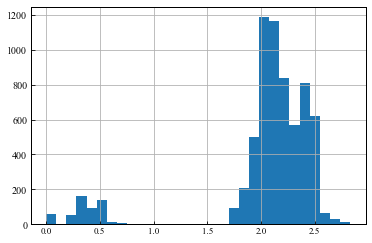

In [169]:
df_2018_mean_dropped['vel_P_Tot'].hist(bins=30)

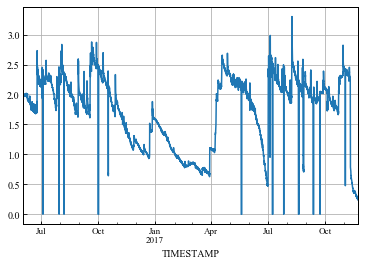

In [170]:
# df_2017_mean_dropped['vel_P_Tot'].plot()
df_2017_mean['vel_P_Tot'].plot()

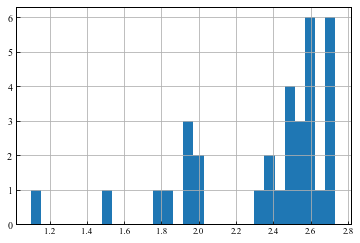

In [171]:
# df_2017_mean['vel_P_Tot'].hist(bins=30)
df_2017_mean_dropped['vel_P_Tot'][df_2017_mean['Load_Avg_difference'] > 1].hist(bins=30)
# df_2017_mean['vel_P_Tot'][(df_2017_mean['vel_P_Tot'] > 2)&(df_2017_mean['vel_P_Tot'] < 2.5)].hist(bins=30)

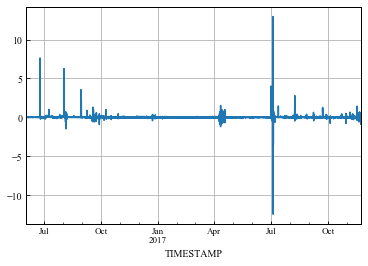

In [172]:
df_2017_mean['Load_Avg_difference'].plot()

## 流速によって分ける

In [173]:
list_of_dfs_2017_mean_vel = []

list_of_dfs_2017_mean_vel.append(df_2017_dia_mean_dropped[(df_2017_mean['vel_P_Tot'] > 1.5)&(df_2017_mean['vel_P_Tot'] < 2)])
list_of_dfs_2017_mean_vel.append(df_2017_dia_mean_dropped[(df_2017_mean['vel_P_Tot'] > 2)&(df_2017_mean['vel_P_Tot'] < 2.5)])
list_of_dfs_2017_mean_vel.append(df_2017_dia_mean_dropped[(df_2017_mean['vel_P_Tot'] > 2.5)&(df_2017_mean['vel_P_Tot'] < 3)])
list_of_dfs_2017_mean_vel.append(df_2017_dia_mean_dropped[(df_2017_mean['vel_P_Tot'] > 3)&(df_2017_mean['vel_P_Tot'] < 3.5)])


C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


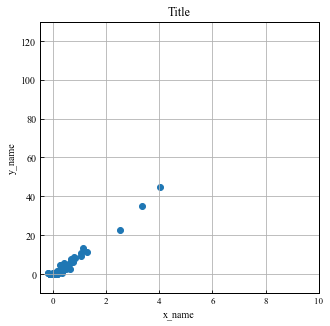

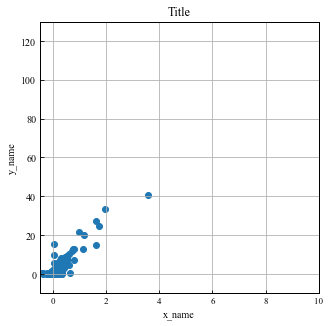

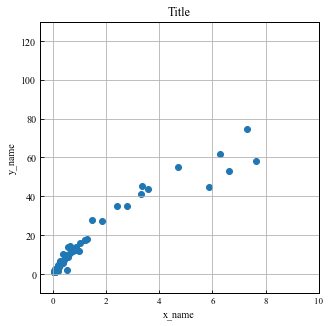

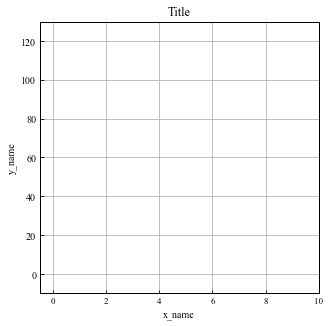

In [174]:
selected_tot = 'hp_Tot(7)'
for df in list_of_dfs_2017_mean_vel:
    dispgraphs.scatter_graph(df, y_name=selected_tot, x_name='Load_Avg_difference', linear_regression=False)
    plt.ylim(-10, 130)
    plt.xlim(-0.5, 10)


ファイルが重くなってきたので2枚目に行きます。時間があればメモリを少なくして1枚におさめたい。

# 使用メモリ確認

In [175]:
import sys

print("{}{: >25}{}{: >10}{}".format('|','Variable Name','|','Memory','|'))
print(" ------------------------------------ ")
for var_name in dir():
    if not var_name.startswith("_") and sys.getsizeof(eval(var_name)) > 10000: #ここだけアレンジ
        print("{}{: >25}{}{: >10}{}".format('|',var_name,'|',sys.getsizeof(eval(var_name)),'|'))
        
#もし消したいメモリがあれば
# del df_2017
# del df_2018

|            Variable Name|    Memory|
 ------------------------------------ 
|                  df_2017| 193217464|
|df_2017_921_dia_mean_dropped|     10664|
|df_2017_921_dia_mean_dropped_weigh|     10664|
|    df_2017_921_dia_weigh|    253552|
|df_2017_921_dia_weigh_sum|     46120|
|              df_2017_dia| 107094504|
|        df_2017_dia2_mean|   1652760|
|         df_2017_dia_mean|   2892312|
| df_2017_dia_mean_dropped|   1213512|
|df_2017_dia_mean_dropped_weigh|   1023696|
|df_2017_dia_mean_dropped_weigh_sum|    454248|
|        df_2017_dia_weigh|  88639584|
|    df_2017_dia_weigh_sum|  33274824|
|             df_2017_mean|   7095320|
|     df_2017_mean_dropped|   1771640|
|df_2018_415_dia_mean_dropped|    263592|
|df_2018_415_dia_mean_dropped_weigh|    263592|
|    df_2018_415_dia_weigh|   1520576|
|df_2018_415_dia_weigh_sum|    276488|
|df_2018_716_dia_mean_dropped|    832680|
|df_2018_716_dia_mean_dropped_weigh|    832680|
|df_2018_716_dia_mean_dropped_weigh_sum|     14632|
|

# Playground